In [1]:
from opensoundscape.preprocess.preprocessors import BasePreprocessor, AudioToSpectrogramPreprocessor, CnnPreprocessor
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
from opensoundscape.torch.models import cnn
from opensoundscape.torch.architectures import cnn_architectures
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from opensoundscape.annotations import categorical_to_one_hot
import matplotlib.pyplot as plt
from opensoundscape.torch.models.cnn import load_model

In [2]:
high_level_name = "automated_cosmos_tweety_to_file_normal"

### Read the train/validation and test data

In [3]:
audio_folder = "D:/open_soundscape_files/"
name = "C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/automated_cosmos_tweety_to_file.csv"
#_TRAINING.csv"
train_val_df = pd.read_csv(name + '_yanChunk_TRAINING.csv')
train_val_df["file"] = audio_folder +train_val_df["file"]

test_df = pd.read_csv(name + '_yanChunk_TESTING.csv')
test_df["file"] = audio_folder +test_df["file"]
model_save = './model/' + 'test_for_reformed_dataset/'

In [4]:
test_df

,Unnamed: 0,file,start_time,end_time,SAMPLING RATE,MANUAL ID
0,0,D:/open_soundscape_files/./Cosmos_data/Testing...,0.0,3.0,44100,Celeus grammicus
1,1,D:/open_soundscape_files/./Cosmos_data/Testing...,3.0,6.0,44100,Celeus grammicus
2,2,D:/open_soundscape_files/./Cosmos_data/Testing...,6.0,9.0,44100,no bird
3,3,D:/open_soundscape_files/./Cosmos_data/Testing...,9.0,12.0,44100,Celeus grammicus
4,4,D:/open_soundscape_files/./Cosmos_data/Testing...,12.0,15.0,44100,Celeus grammicus
...,...,...,...,...,...,...
6432,6432,D:/open_soundscape_files/./Cosmos_data/Testing...,15.0,18.0,44100,Tolmomyias sulphurescens
6433,6433,D:/open_soundscape_files/./Cosmos_data/Testing...,18.0,21.0,44100,no bird
6434,6434,D:/open_soundscape_files/./Cosmos_data/Testing...,21.0,24.0,44100,Tolmomyias sulphurescens
6435,6435,D:/open_soundscape_files/./Cosmos_data/Testing...,24.0,27.0,44100,Tolmomyias sulphurescens


In [5]:
test_df.shape

(6437, 6)

In [6]:
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram

In [7]:
train_val_df['MANUAL ID'].value_counts()

no bird                     14606
Microcerculus marginatus    11935
Ramphastos tucanus          10388
Zonotrichia capensis        10191
Turdus leucomelas            9459
Tolmomyias sulphurescens     8876
Trogon viridis               7833
Xiphorhynchus guttatus       7804
Myioborus miniatus           3118
Thraupis episcopus           3056
Celeus grammicus             1783
Name: MANUAL ID, dtype: int64

In [8]:
train_val_df["filename"] = train_val_df["file"].apply(lambda x: x.split("/")[-1])
train_val_df.head()

,Unnamed: 0,file,start_time,end_time,SAMPLING RATE,MANUAL ID,filename
0,0,D:/open_soundscape_files/./Cosmos_data/Trainin...,0.0,3.0,44100,Thraupis episcopus,XC100073 - Blue-grey Tanager - Thraupis episco...
1,1,D:/open_soundscape_files/./Cosmos_data/Trainin...,1.5,4.5,44100,Thraupis episcopus,XC100073 - Blue-grey Tanager - Thraupis episco...
2,2,D:/open_soundscape_files/./Cosmos_data/Trainin...,0.0,3.0,44100,Thraupis episcopus,XC100092 - Blue-grey Tanager - Thraupis episco...
3,3,D:/open_soundscape_files/./Cosmos_data/Trainin...,1.5,4.5,44100,Thraupis episcopus,XC100092 - Blue-grey Tanager - Thraupis episco...
4,4,D:/open_soundscape_files/./Cosmos_data/Trainin...,3.0,6.0,44100,Thraupis episcopus,XC100092 - Blue-grey Tanager - Thraupis episco...


In [9]:
test_df.head()

,Unnamed: 0,file,start_time,end_time,SAMPLING RATE,MANUAL ID
0,0,D:/open_soundscape_files/./Cosmos_data/Testing...,0.0,3.0,44100,Celeus grammicus
1,1,D:/open_soundscape_files/./Cosmos_data/Testing...,3.0,6.0,44100,Celeus grammicus
2,2,D:/open_soundscape_files/./Cosmos_data/Testing...,6.0,9.0,44100,no bird
3,3,D:/open_soundscape_files/./Cosmos_data/Testing...,9.0,12.0,44100,Celeus grammicus
4,4,D:/open_soundscape_files/./Cosmos_data/Testing...,12.0,15.0,44100,Celeus grammicus


In [10]:
test_df["filename"] = test_df["file"].apply(lambda x: x.split("/")[-1])
test_df.head()

,Unnamed: 0,file,start_time,end_time,SAMPLING RATE,MANUAL ID,filename
0,0,D:/open_soundscape_files/./Cosmos_data/Testing...,0.0,3.0,44100,Celeus grammicus,XC87449 - Scaly-breasted Woodpecker - Celeus g...
1,1,D:/open_soundscape_files/./Cosmos_data/Testing...,3.0,6.0,44100,Celeus grammicus,XC87449 - Scaly-breasted Woodpecker - Celeus g...
2,2,D:/open_soundscape_files/./Cosmos_data/Testing...,6.0,9.0,44100,no bird,XC87449 - Scaly-breasted Woodpecker - Celeus g...
3,3,D:/open_soundscape_files/./Cosmos_data/Testing...,9.0,12.0,44100,Celeus grammicus,XC87449 - Scaly-breasted Woodpecker - Celeus g...
4,4,D:/open_soundscape_files/./Cosmos_data/Testing...,12.0,15.0,44100,Celeus grammicus,XC87449 - Scaly-breasted Woodpecker - Celeus g...


In [11]:
train_val_df = train_val_df[~train_val_df["filename"].isin(test_df["filename"])]
test_df.merge(train_val_df, left_on="filename", right_on="filename")

,Unnamed: 0_x,file_x,start_time_x,end_time_x,SAMPLING RATE_x,MANUAL ID_x,filename,Unnamed: 0_y,file_y,start_time_y,end_time_y,SAMPLING RATE_y,MANUAL ID_y


In [12]:
def remove_denoise_audio(x):
    return x.replace("temp_clips", "temp_clips - Copy")


#train_val_df["file"] = train_val_df["file"].apply(remove_denoise_audio)

### Check counts of the different classes in both the dataframes

In [13]:
import os


In [14]:
no_bird = pd.read_csv(os.getcwd()+'\\none_test.csv')
no_bird["MANUAL ID"] = "Absent"
#other_bird = 
other_bird = train_val_df[train_val_df["MANUAL ID"] == "bird"].sample(0)
train_val_df = train_val_df[~train_val_df["MANUAL ID"].isin(["bird"])]






train_val_df = train_val_df#.append(no_bird).append(other_bird)
train_val_df

,Unnamed: 0,file,start_time,end_time,SAMPLING RATE,MANUAL ID,filename
0,0,D:/open_soundscape_files/./Cosmos_data/Trainin...,0.0,3.0,44100,Thraupis episcopus,XC100073 - Blue-grey Tanager - Thraupis episco...
1,1,D:/open_soundscape_files/./Cosmos_data/Trainin...,1.5,4.5,44100,Thraupis episcopus,XC100073 - Blue-grey Tanager - Thraupis episco...
2,2,D:/open_soundscape_files/./Cosmos_data/Trainin...,0.0,3.0,44100,Thraupis episcopus,XC100092 - Blue-grey Tanager - Thraupis episco...
3,3,D:/open_soundscape_files/./Cosmos_data/Trainin...,1.5,4.5,44100,Thraupis episcopus,XC100092 - Blue-grey Tanager - Thraupis episco...
4,4,D:/open_soundscape_files/./Cosmos_data/Trainin...,3.0,6.0,44100,Thraupis episcopus,XC100092 - Blue-grey Tanager - Thraupis episco...
...,...,...,...,...,...,...,...
89044,89044,D:/open_soundscape_files/./Cosmos_data/Trainin...,33.0,36.0,44100,no bird,Zonotrichia-capensis-47546_33.0.wav
89045,89045,D:/open_soundscape_files/./Cosmos_data/Trainin...,34.5,37.5,44100,no bird,Zonotrichia-capensis-47546_34.5.wav
89046,89046,D:/open_soundscape_files/./Cosmos_data/Trainin...,36.0,39.0,44100,no bird,Zonotrichia-capensis-47546_36.0.wav
89047,89047,D:/open_soundscape_files/./Cosmos_data/Trainin...,37.5,40.5,44100,no bird,Zonotrichia-capensis-47546_37.5.wav


In [15]:
species = np.unique(train_val_df['MANUAL ID'])
species

array(['Celeus grammicus', 'Microcerculus marginatus',
       'Myioborus miniatus', 'Ramphastos tucanus', 'Thraupis episcopus',
       'Tolmomyias sulphurescens', 'Trogon viridis', 'Turdus leucomelas',
       'Xiphorhynchus guttatus', 'Zonotrichia capensis', 'no bird'],
      dtype=object)

In [16]:
test_df

,Unnamed: 0,file,start_time,end_time,SAMPLING RATE,MANUAL ID,filename
0,0,D:/open_soundscape_files/./Cosmos_data/Testing...,0.0,3.0,44100,Celeus grammicus,XC87449 - Scaly-breasted Woodpecker - Celeus g...
1,1,D:/open_soundscape_files/./Cosmos_data/Testing...,3.0,6.0,44100,Celeus grammicus,XC87449 - Scaly-breasted Woodpecker - Celeus g...
2,2,D:/open_soundscape_files/./Cosmos_data/Testing...,6.0,9.0,44100,no bird,XC87449 - Scaly-breasted Woodpecker - Celeus g...
3,3,D:/open_soundscape_files/./Cosmos_data/Testing...,9.0,12.0,44100,Celeus grammicus,XC87449 - Scaly-breasted Woodpecker - Celeus g...
4,4,D:/open_soundscape_files/./Cosmos_data/Testing...,12.0,15.0,44100,Celeus grammicus,XC87449 - Scaly-breasted Woodpecker - Celeus g...
...,...,...,...,...,...,...,...
6432,6432,D:/open_soundscape_files/./Cosmos_data/Testing...,15.0,18.0,44100,Tolmomyias sulphurescens,XC27942 - Yellow-olive Flatbill - Tolmomyias s...
6433,6433,D:/open_soundscape_files/./Cosmos_data/Testing...,18.0,21.0,44100,no bird,XC27942 - Yellow-olive Flatbill - Tolmomyias s...
6434,6434,D:/open_soundscape_files/./Cosmos_data/Testing...,21.0,24.0,44100,Tolmomyias sulphurescens,XC27942 - Yellow-olive Flatbill - Tolmomyias s...
6435,6435,D:/open_soundscape_files/./Cosmos_data/Testing...,24.0,27.0,44100,Tolmomyias sulphurescens,XC27942 - Yellow-olive Flatbill - Tolmomyias s...


In [17]:
#TODO FIX THIS
species = classes = np.unique(test_df['MANUAL ID'])
def fix_classes(label):
    if (label=="Absent"):
        return "no bird"
    if (not label in species or label=="Lipaugus vociferans"):
        return "Delete"
    return label

def fix_classes2(label):
    if(label=="bird" or label=="Bird"):
        return "bird"
    if (label=="Absent" or label=="No class of interest"):
        return "no bird"
    if (not label in species or label=="Lipaugus vociferans"):
        return "Delete"
    return label


train_val_df['MANUAL ID'] = train_val_df["MANUAL ID"].apply(fix_classes)
test_df['MANUAL ID'] = test_df["MANUAL ID"].apply(fix_classes2)

train_val_df = train_val_df[train_val_df["MANUAL ID"] != "Delete"]
test_df = test_df[test_df["MANUAL ID"] != "Delete"]

In [18]:
train_val_df['MANUAL ID'].value_counts()

no bird                     14606
Microcerculus marginatus    11100
Zonotrichia capensis         9389
Ramphastos tucanus           9267
Turdus leucomelas            8592
Tolmomyias sulphurescens     8123
Xiphorhynchus guttatus       7110
Trogon viridis               7038
Myioborus miniatus           2516
Thraupis episcopus           2289
Celeus grammicus             1213
Name: MANUAL ID, dtype: int64

In [19]:
train_val_df['MANUAL ID'].value_counts().sum()

81243

In [20]:
test_df['MANUAL ID'].value_counts()

no bird                     1752
bird                         954
Ramphastos tucanus           552
Turdus leucomelas            493
Microcerculus marginatus     439
Zonotrichia capensis         398
Tolmomyias sulphurescens     368
Trogon viridis               357
Xiphorhynchus guttatus       335
Myioborus miniatus           314
Thraupis episcopus           248
Celeus grammicus             224
Name: MANUAL ID, dtype: int64

### Changing species' names to a simpler version for convenience

In [21]:
#train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Toucan'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Toucan'), 'MANUAL ID'] = 'Toucan'
#train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Flycatcher'), 'MANUAL ID'] = 'Flycatcher'
#train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Thrush'), 'MANUAL ID'] = 'Thrush'
#train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Vireo'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Vireo'), 'MANUAL ID'] = 'Vireo'
#train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Antwren'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Antwren'), 'MANUAL ID'] = 'Antwren'
#train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Tanager'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Tanager'), 'MANUAL ID'] = 'Tanager'
#train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Kingbird'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Kingbird'), 'MANUAL ID'] = 'Kingbird'
#train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Tody-Tyrant'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Tody-Tyrant'), 'MANUAL ID'] = 'Tody-Tyrant'
#train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Hummingbird'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Hummingbird'), 'MANUAL ID'] = 'Hummingbird'
#train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Antshrike'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Antshrike'), 'MANUAL ID'] = 'Antshrike'

In [22]:
other_bird = train_val_df[~(train_val_df["MANUAL ID"].isin(classes))]
other_bird["MANUAL ID"] = "bird"

### Remove rows from dataframes which are not the species of our interest

In [23]:
classes = np.unique(test_df['MANUAL ID'])#["Zonotrichia capensis", "other", "bird"] ##['Antwren', 'Antshrike', 'Toucan', 'Vireo', 'Kingbird', 'Tody-Tyrant', 'None']
train_val_df[~(train_val_df["MANUAL ID"].isin(classes))]["MANUAL ID"] = "bird"
train_val_df = train_val_df[train_val_df["MANUAL ID"].isin(classes)]
train_val_df = train_val_df.append(other_bird)
test_df = test_df[test_df["MANUAL ID"].isin(classes)]
print('Classwise Counts for train/val data:')
print(train_val_df['MANUAL ID'].value_counts())
print('\nClasswise  Counts for test data:')
print(test_df['MANUAL ID'].value_counts())

Classwise Counts for train/val data:
no bird                     14606
Microcerculus marginatus    11100
Zonotrichia capensis         9389
Ramphastos tucanus           9267
Turdus leucomelas            8592
Tolmomyias sulphurescens     8123
Xiphorhynchus guttatus       7110
Trogon viridis               7038
Myioborus miniatus           2516
Thraupis episcopus           2289
Celeus grammicus             1213
Name: MANUAL ID, dtype: int64

Classwise  Counts for test data:
no bird                     1752
bird                         954
Ramphastos tucanus           552
Turdus leucomelas            493
Microcerculus marginatus     439
Zonotrichia capensis         398
Tolmomyias sulphurescens     368
Trogon viridis               357
Xiphorhynchus guttatus       335
Myioborus miniatus           314
Thraupis episcopus           248
Celeus grammicus             224
Name: MANUAL ID, dtype: int64


### Convert the train/val and test data to one-hot representations of the classes

In [24]:
# Train/val
one_hot_labels, train_classes = categorical_to_one_hot(train_val_df[['MANUAL ID']].values)
train_val_df = pd.DataFrame(index=train_val_df['file'],data=one_hot_labels,columns=train_classes)

# Test
one_hot_labels, test_classes = categorical_to_one_hot(test_df[['MANUAL ID']].values)
test_df = pd.DataFrame(index=test_df['file'],data=one_hot_labels,columns=test_classes)

In [25]:
test_df

,Microcerculus marginatus,Myioborus miniatus,Thraupis episcopus,bird,Ramphastos tucanus,Xiphorhynchus guttatus,no bird,Celeus grammicus,Zonotrichia capensis,Trogon viridis,Turdus leucomelas,Tolmomyias sulphurescens
file,,,,,,,,,,,,
D:/open_soundscape_files/./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_0.0.wav,0,0,0,0,0,0,0,1,0,0,0,0
D:/open_soundscape_files/./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_3.0.wav,0,0,0,0,0,0,0,1,0,0,0,0
D:/open_soundscape_files/./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_6.0.wav,0,0,0,0,0,0,1,0,0,0,0,0
D:/open_soundscape_files/./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_9.0.wav,0,0,0,0,0,0,0,1,0,0,0,0
D:/open_soundscape_files/./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_12.0.wav,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
D:/open_soundscape_files/./Cosmos_data/Testing/XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_15.0.wav,0,0,0,0,0,0,0,0,0,0,0,1
D:/open_soundscape_files/./Cosmos_data/Testing/XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_18.0.wav,0,0,0,0,0,0,1,0,0,0,0,0
D:/open_soundscape_files/./Cosmos_data/Testing/XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_21.0.wav,0,0,0,0,0,0,0,0,0,0,0,1


### Split the trainining/validation dataframe into training and validation sets

In [26]:
train_df, valid_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

In [27]:
print("Number of training examples : ", train_df.shape[0])
print("Number of validation examples : ", valid_df.shape[0])
print("Number of test examples : ", test_df.shape[0])

Number of training examples :  64994
Number of validation examples :  16249
Number of test examples :  6434


### Prepare the training and validation set for the CNN model

In [28]:
train_dataset = CnnPreprocessor(df=train_df)
train_dataset.augmentation_on()
train_dataset.actions.load_audio.set(sample_rate=44100)
valid_dataset = CnnPreprocessor(df=valid_df)
valid_dataset.augmentation_on()
valid_dataset.actions.load_audio.set(sample_rate=44100)

In [29]:
dir(cnn)

['BCEWithLogitsLoss_hot',
 'BaseModule',
 'CnnResampleLoss',
 'CrossEntropyLoss_hot',
 'F',
 'InceptionV3',
 'InceptionV3ResampleLoss',
 'OrderedDict',
 'Path',
 'PytorchModel',
 'ResampleLoss',
 'Resnet18Binary',
 'Resnet18Multiclass',
 'SafeDataset',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'apply_activation_layer',
 'binary_metrics',
 'cnn_architectures',
 'collate_lists_of_audio_clips',
 'datetime',
 'deprecated',
 'get_batch',
 'get_dataloader',
 'hamming_loss',
 'jaccard_score',
 'load_model',
 'load_outdated_model',
 'multiclass_metrics',
 'np',
 'opensoundscape',
 'optim',
 'os',
 'pd',
 'precision_recall_fscore_support',
 'random',
 'tensor_binary_predictions',
 'torch',
 'warnings']

### Create the Resnet-18 Multiclass model and train it

In [30]:
train_classes

['Microcerculus marginatus',
 'Myioborus miniatus',
 'Thraupis episcopus',
 'Ramphastos tucanus',
 'Xiphorhynchus guttatus',
 'no bird',
 'Celeus grammicus',
 'Zonotrichia capensis',
 'Trogon viridis',
 'Turdus leucomelas',
 'Tolmomyias sulphurescens']

In [31]:
arch = cnn.cnn_architectures.resnet50(num_classes=len(train_classes))
model = cnn.PytorchModel(arch,train_classes,single_target=False)

#model = cnn.Resnet18Multiclass(train_classes)

C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


created PytorchModel model object with 11 classes


In [32]:
dir(model.network)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_forward_hooks',
 '_forward_impl',
 '_forward_pre_hooks',
 '_get_backward_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_make_layer',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_set',
 '_norm_layer',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dic

In [33]:
model.optimizer_params = {  # optimizer parameters for classification layers
            # "params": self.network.parameters(),
            "lr": 0.001,
            "momentum": 0.99,
            "weight_decay": 0.0005,
        }

In [34]:
#name = "C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/model/automated_cosmos_tweety_to_file_warblar_no_bird_test_4_5_epochs/"
#model_save = name
#model_save

In [35]:
model.sampler = 'imbalanced'
model.train(
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    save_path=model_save,
    batch_size=16,
    save_interval=100,
    num_workers=2,
    epochs=3
)

Epoch: 0 [batch 0/4063 (0.00%)] 
	Jacc: 0.091 Hamm: 0.909 DistLoss: 0.684
Epoch: 0 [batch 10/4063 (0.25%)] 
	Jacc: 0.095 Hamm: 0.767 DistLoss: 0.581
Epoch: 0 [batch 20/4063 (0.49%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 0.467


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 30/4063 (0.74%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 0.425


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 40/4063 (0.98%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 0.420


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 50/4063 (1.23%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 0.429


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 60/4063 (1.48%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 0.441


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 70/4063 (1.72%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 0.451


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 80/4063 (1.97%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 0.455


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 90/4063 (2.22%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 0.452


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 100/4063 (2.46%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 0.443


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 110/4063 (2.71%)] 
	Jacc: 0.167 Hamm: 0.091 DistLoss: 0.433


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 120/4063 (2.95%)] 
	Jacc: 0.057 Hamm: 0.244 DistLoss: 0.424


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 130/4063 (3.20%)] 
	Jacc: 0.136 Hamm: 0.284 DistLoss: 0.418
Epoch: 0 [batch 140/4063 (3.45%)] 
	Jacc: 0.189 Hamm: 0.324 DistLoss: 0.413
Epoch: 0 [batch 150/4063 (3.69%)] 
	Jacc: 0.063 Hamm: 0.244 DistLoss: 0.408


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 160/4063 (3.94%)] 
	Jacc: 0.039 Hamm: 0.153 DistLoss: 0.402


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 170/4063 (4.18%)] 
	Jacc: 0.000 Hamm: 0.097 DistLoss: 0.396


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 180/4063 (4.43%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 0.390


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 190/4063 (4.68%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 0.385


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 200/4063 (4.92%)] 
	Jacc: 0.000 Hamm: 0.091 DistLoss: 0.381


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 210/4063 (5.17%)] 
	Jacc: 0.212 Hamm: 0.074 DistLoss: 0.376


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 220/4063 (5.41%)] 
	Jacc: 0.197 Hamm: 0.097 DistLoss: 0.371


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 230/4063 (5.66%)] 
	Jacc: 0.121 Hamm: 0.114 DistLoss: 0.366


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 240/4063 (5.91%)] 
	Jacc: 0.341 Hamm: 0.091 DistLoss: 0.361


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 250/4063 (6.15%)] 
	Jacc: 0.189 Hamm: 0.142 DistLoss: 0.356
Epoch: 0 [batch 260/4063 (6.40%)] 
	Jacc: 0.235 Hamm: 0.131 DistLoss: 0.352


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 270/4063 (6.65%)] 
	Jacc: 0.220 Hamm: 0.153 DistLoss: 0.348
Epoch: 0 [batch 280/4063 (6.89%)] 
	Jacc: 0.189 Hamm: 0.136 DistLoss: 0.344
Epoch: 0 [batch 290/4063 (7.14%)] 
	Jacc: 0.477 Hamm: 0.097 DistLoss: 0.340
Epoch: 0 [batch 300/4063 (7.38%)] 
	Jacc: 0.215 Hamm: 0.108 DistLoss: 0.336


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 310/4063 (7.63%)] 
	Jacc: 0.402 Hamm: 0.097 DistLoss: 0.332
Epoch: 0 [batch 320/4063 (7.88%)] 
	Jacc: 0.576 Hamm: 0.051 DistLoss: 0.328
Epoch: 0 [batch 330/4063 (8.12%)] 
	Jacc: 0.364 Hamm: 0.080 DistLoss: 0.325
Epoch: 0 [batch 340/4063 (8.37%)] 
	Jacc: 0.417 Hamm: 0.051 DistLoss: 0.322


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 350/4063 (8.61%)] 
	Jacc: 0.364 Hamm: 0.068 DistLoss: 0.318


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 360/4063 (8.86%)] 
	Jacc: 0.121 Hamm: 0.114 DistLoss: 0.315


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 370/4063 (9.11%)] 
	Jacc: 0.477 Hamm: 0.062 DistLoss: 0.312


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 380/4063 (9.35%)] 
	Jacc: 0.235 Hamm: 0.131 DistLoss: 0.309
Epoch: 0 [batch 390/4063 (9.60%)] 
	Jacc: 0.409 Hamm: 0.085 DistLoss: 0.306


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 400/4063 (9.84%)] 
	Jacc: 0.370 Hamm: 0.097 DistLoss: 0.303
Epoch: 0 [batch 410/4063 (10.09%)] 
	Jacc: 0.333 Hamm: 0.097 DistLoss: 0.300


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 420/4063 (10.34%)] 
	Jacc: 0.094 Hamm: 0.142 DistLoss: 0.298
Epoch: 0 [batch 430/4063 (10.58%)] 
	Jacc: 0.250 Hamm: 0.091 DistLoss: 0.295


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 440/4063 (10.83%)] 
	Jacc: 0.333 Hamm: 0.091 DistLoss: 0.292


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 450/4063 (11.08%)] 
	Jacc: 0.364 Hamm: 0.080 DistLoss: 0.289
Epoch: 0 [batch 460/4063 (11.32%)] 
	Jacc: 0.276 Hamm: 0.091 DistLoss: 0.287


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 470/4063 (11.57%)] 
	Jacc: 0.485 Hamm: 0.040 DistLoss: 0.284


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 480/4063 (11.81%)] 
	Jacc: 0.477 Hamm: 0.062 DistLoss: 0.282


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 490/4063 (12.06%)] 
	Jacc: 0.455 Hamm: 0.080 DistLoss: 0.280
Epoch: 0 [batch 500/4063 (12.31%)] 
	Jacc: 0.382 Hamm: 0.080 DistLoss: 0.278
Epoch: 0 [batch 510/4063 (12.55%)] 
	Jacc: 0.367 Hamm: 0.074 DistLoss: 0.276
Epoch: 0 [batch 520/4063 (12.80%)] 
	Jacc: 0.339 Hamm: 0.080 DistLoss: 0.274


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 530/4063 (13.04%)] 
	Jacc: 0.523 Hamm: 0.068 DistLoss: 0.271
Epoch: 0 [batch 540/4063 (13.29%)] 
	Jacc: 0.606 Hamm: 0.062 DistLoss: 0.269
Epoch: 0 [batch 550/4063 (13.54%)] 
	Jacc: 0.439 Hamm: 0.057 DistLoss: 0.268


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 560/4063 (13.78%)] 
	Jacc: 0.492 Hamm: 0.062 DistLoss: 0.266
Epoch: 0 [batch 570/4063 (14.03%)] 
	Jacc: 0.242 Hamm: 0.102 DistLoss: 0.264


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 580/4063 (14.28%)] 
	Jacc: 0.386 Hamm: 0.102 DistLoss: 0.263
Epoch: 0 [batch 590/4063 (14.52%)] 
	Jacc: 0.568 Hamm: 0.057 DistLoss: 0.261
Epoch: 0 [batch 600/4063 (14.77%)] 
	Jacc: 0.697 Hamm: 0.028 DistLoss: 0.259


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 610/4063 (15.01%)] 
	Jacc: 0.273 Hamm: 0.091 DistLoss: 0.258


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 620/4063 (15.26%)] 
	Jacc: 0.455 Hamm: 0.068 DistLoss: 0.257
Epoch: 0 [batch 630/4063 (15.51%)] 
	Jacc: 0.318 Hamm: 0.085 DistLoss: 0.255
Epoch: 0 [batch 640/4063 (15.75%)] 
	Jacc: 0.606 Hamm: 0.034 DistLoss: 0.253


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 650/4063 (16.00%)] 
	Jacc: 0.311 Hamm: 0.062 DistLoss: 0.252


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 660/4063 (16.24%)] 
	Jacc: 0.424 Hamm: 0.068 DistLoss: 0.250


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 670/4063 (16.49%)] 
	Jacc: 0.623 Hamm: 0.045 DistLoss: 0.249


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 680/4063 (16.74%)] 
	Jacc: 0.644 Hamm: 0.051 DistLoss: 0.247


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 690/4063 (16.98%)] 
	Jacc: 0.697 Hamm: 0.040 DistLoss: 0.246
Epoch: 0 [batch 700/4063 (17.23%)] 
	Jacc: 0.371 Hamm: 0.080 DistLoss: 0.245


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 710/4063 (17.47%)] 
	Jacc: 0.521 Hamm: 0.074 DistLoss: 0.243
Epoch: 0 [batch 720/4063 (17.72%)] 
	Jacc: 0.492 Hamm: 0.040 DistLoss: 0.242


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 730/4063 (17.97%)] 
	Jacc: 0.432 Hamm: 0.068 DistLoss: 0.241


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 740/4063 (18.21%)] 
	Jacc: 0.470 Hamm: 0.068 DistLoss: 0.239
Epoch: 0 [batch 750/4063 (18.46%)] 
	Jacc: 0.636 Hamm: 0.057 DistLoss: 0.238
Epoch: 0 [batch 760/4063 (18.71%)] 
	Jacc: 0.455 Hamm: 0.068 DistLoss: 0.236
Epoch: 0 [batch 770/4063 (18.95%)] 
	Jacc: 0.583 Hamm: 0.045 DistLoss: 0.235
Epoch: 0 [batch 780/4063 (19.20%)] 
	Jacc: 0.314 Hamm: 0.085 DistLoss: 0.234


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 790/4063 (19.44%)] 
	Jacc: 0.720 Hamm: 0.017 DistLoss: 0.233


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 800/4063 (19.69%)] 
	Jacc: 0.321 Hamm: 0.097 DistLoss: 0.232


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 810/4063 (19.94%)] 
	Jacc: 0.371 Hamm: 0.068 DistLoss: 0.231


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 820/4063 (20.18%)] 
	Jacc: 0.545 Hamm: 0.057 DistLoss: 0.230


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 830/4063 (20.43%)] 
	Jacc: 0.636 Hamm: 0.034 DistLoss: 0.229


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 840/4063 (20.67%)] 
	Jacc: 0.591 Hamm: 0.068 DistLoss: 0.228
Epoch: 0 [batch 850/4063 (20.92%)] 
	Jacc: 0.455 Hamm: 0.057 DistLoss: 0.227


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 860/4063 (21.17%)] 
	Jacc: 0.173 Hamm: 0.108 DistLoss: 0.226


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 870/4063 (21.41%)] 
	Jacc: 0.530 Hamm: 0.034 DistLoss: 0.225


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 880/4063 (21.66%)] 
	Jacc: 0.561 Hamm: 0.062 DistLoss: 0.224
Epoch: 0 [batch 890/4063 (21.90%)] 
	Jacc: 0.447 Hamm: 0.051 DistLoss: 0.223


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 900/4063 (22.15%)] 
	Jacc: 0.386 Hamm: 0.097 DistLoss: 0.222
Epoch: 0 [batch 910/4063 (22.40%)] 
	Jacc: 0.515 Hamm: 0.040 DistLoss: 0.221


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 920/4063 (22.64%)] 
	Jacc: 0.667 Hamm: 0.040 DistLoss: 0.220
Epoch: 0 [batch 930/4063 (22.89%)] 
	Jacc: 0.318 Hamm: 0.097 DistLoss: 0.219
Epoch: 0 [batch 940/4063 (23.14%)] 
	Jacc: 0.515 Hamm: 0.045 DistLoss: 0.219


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 950/4063 (23.38%)] 
	Jacc: 0.500 Hamm: 0.051 DistLoss: 0.218


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 960/4063 (23.63%)] 
	Jacc: 0.492 Hamm: 0.062 DistLoss: 0.217


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 970/4063 (23.87%)] 
	Jacc: 0.318 Hamm: 0.097 DistLoss: 0.217
Epoch: 0 [batch 980/4063 (24.12%)] 
	Jacc: 0.545 Hamm: 0.040 DistLoss: 0.216


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 990/4063 (24.37%)] 
	Jacc: 0.606 Hamm: 0.045 DistLoss: 0.215
Epoch: 0 [batch 1000/4063 (24.61%)] 
	Jacc: 0.462 Hamm: 0.068 DistLoss: 0.214
Epoch: 0 [batch 1010/4063 (24.86%)] 
	Jacc: 0.417 Hamm: 0.091 DistLoss: 0.214
Epoch: 0 [batch 1020/4063 (25.10%)] 
	Jacc: 0.545 Hamm: 0.091 DistLoss: 0.213
Epoch: 0 [batch 1030/4063 (25.35%)] 
	Jacc: 0.523 Hamm: 0.068 DistLoss: 0.212


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1040/4063 (25.60%)] 
	Jacc: 0.341 Hamm: 0.085 DistLoss: 0.211


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1050/4063 (25.84%)] 
	Jacc: 0.576 Hamm: 0.057 DistLoss: 0.211
Epoch: 0 [batch 1060/4063 (26.09%)] 
	Jacc: 0.524 Hamm: 0.045 DistLoss: 0.210


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1070/4063 (26.34%)] 
	Jacc: 0.506 Hamm: 0.074 DistLoss: 0.209
Epoch: 0 [batch 1080/4063 (26.58%)] 
	Jacc: 0.402 Hamm: 0.062 DistLoss: 0.209


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1090/4063 (26.83%)] 
	Jacc: 0.379 Hamm: 0.074 DistLoss: 0.208
Epoch: 0 [batch 1100/4063 (27.07%)] 
	Jacc: 0.348 Hamm: 0.091 DistLoss: 0.207
Epoch: 0 [batch 1110/4063 (27.32%)] 
	Jacc: 0.485 Hamm: 0.057 DistLoss: 0.206


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1120/4063 (27.57%)] 
	Jacc: 0.515 Hamm: 0.045 DistLoss: 0.206


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1130/4063 (27.81%)] 
	Jacc: 0.530 Hamm: 0.057 DistLoss: 0.205
Epoch: 0 [batch 1140/4063 (28.06%)] 
	Jacc: 0.470 Hamm: 0.062 DistLoss: 0.205
Epoch: 0 [batch 1150/4063 (28.30%)] 
	Jacc: 0.573 Hamm: 0.045 DistLoss: 0.204


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1160/4063 (28.55%)] 
	Jacc: 0.424 Hamm: 0.074 DistLoss: 0.203
Epoch: 0 [batch 1170/4063 (28.80%)] 
	Jacc: 0.379 Hamm: 0.097 DistLoss: 0.203
Epoch: 0 [batch 1180/4063 (29.04%)] 
	Jacc: 0.470 Hamm: 0.068 DistLoss: 0.202
Epoch: 0 [batch 1190/4063 (29.29%)] 
	Jacc: 0.417 Hamm: 0.062 DistLoss: 0.202


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1200/4063 (29.53%)] 
	Jacc: 0.483 Hamm: 0.051 DistLoss: 0.201


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1210/4063 (29.78%)] 
	Jacc: 0.276 Hamm: 0.097 DistLoss: 0.201
Epoch: 0 [batch 1220/4063 (30.03%)] 
	Jacc: 0.352 Hamm: 0.085 DistLoss: 0.200


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1230/4063 (30.27%)] 
	Jacc: 0.518 Hamm: 0.057 DistLoss: 0.200


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1240/4063 (30.52%)] 
	Jacc: 0.555 Hamm: 0.051 DistLoss: 0.199


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1250/4063 (30.77%)] 
	Jacc: 0.371 Hamm: 0.091 DistLoss: 0.199
Epoch: 0 [batch 1260/4063 (31.01%)] 
	Jacc: 0.409 Hamm: 0.074 DistLoss: 0.198


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1270/4063 (31.26%)] 
	Jacc: 0.432 Hamm: 0.068 DistLoss: 0.198
Epoch: 0 [batch 1280/4063 (31.50%)] 
	Jacc: 0.773 Hamm: 0.006 DistLoss: 0.197


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1290/4063 (31.75%)] 
	Jacc: 0.455 Hamm: 0.045 DistLoss: 0.197


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1300/4063 (32.00%)] 
	Jacc: 0.545 Hamm: 0.040 DistLoss: 0.196


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1310/4063 (32.24%)] 
	Jacc: 0.333 Hamm: 0.074 DistLoss: 0.196


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1320/4063 (32.49%)] 
	Jacc: 0.500 Hamm: 0.062 DistLoss: 0.195
Epoch: 0 [batch 1330/4063 (32.73%)] 
	Jacc: 0.545 Hamm: 0.034 DistLoss: 0.195


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1340/4063 (32.98%)] 
	Jacc: 0.515 Hamm: 0.045 DistLoss: 0.194


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1350/4063 (33.23%)] 
	Jacc: 0.424 Hamm: 0.080 DistLoss: 0.194


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1360/4063 (33.47%)] 
	Jacc: 0.515 Hamm: 0.062 DistLoss: 0.193
Epoch: 0 [batch 1370/4063 (33.72%)] 
	Jacc: 0.515 Hamm: 0.045 DistLoss: 0.193


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1380/4063 (33.97%)] 
	Jacc: 0.545 Hamm: 0.040 DistLoss: 0.192


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1390/4063 (34.21%)] 
	Jacc: 0.538 Hamm: 0.057 DistLoss: 0.192
Epoch: 0 [batch 1400/4063 (34.46%)] 
	Jacc: 0.432 Hamm: 0.068 DistLoss: 0.191
Epoch: 0 [batch 1410/4063 (34.70%)] 
	Jacc: 0.765 Hamm: 0.011 DistLoss: 0.191


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1420/4063 (34.95%)] 
	Jacc: 0.367 Hamm: 0.097 DistLoss: 0.190


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1430/4063 (35.20%)] 
	Jacc: 0.530 Hamm: 0.051 DistLoss: 0.189


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1440/4063 (35.44%)] 
	Jacc: 0.614 Hamm: 0.028 DistLoss: 0.189


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1450/4063 (35.69%)] 
	Jacc: 0.417 Hamm: 0.080 DistLoss: 0.189
Epoch: 0 [batch 1460/4063 (35.93%)] 
	Jacc: 0.455 Hamm: 0.057 DistLoss: 0.188


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1470/4063 (36.18%)] 
	Jacc: 0.636 Hamm: 0.028 DistLoss: 0.188
Epoch: 0 [batch 1480/4063 (36.43%)] 
	Jacc: 0.515 Hamm: 0.051 DistLoss: 0.187


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1490/4063 (36.67%)] 
	Jacc: 0.485 Hamm: 0.057 DistLoss: 0.187


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1500/4063 (36.92%)] 
	Jacc: 0.545 Hamm: 0.040 DistLoss: 0.186


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1510/4063 (37.16%)] 
	Jacc: 0.424 Hamm: 0.068 DistLoss: 0.186
Epoch: 0 [batch 1520/4063 (37.41%)] 
	Jacc: 0.582 Hamm: 0.040 DistLoss: 0.186


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1530/4063 (37.66%)] 
	Jacc: 0.567 Hamm: 0.051 DistLoss: 0.185


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1540/4063 (37.90%)] 
	Jacc: 0.347 Hamm: 0.091 DistLoss: 0.185


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1550/4063 (38.15%)] 
	Jacc: 0.615 Hamm: 0.034 DistLoss: 0.184


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1560/4063 (38.40%)] 
	Jacc: 0.561 Hamm: 0.040 DistLoss: 0.184
Epoch: 0 [batch 1570/4063 (38.64%)] 
	Jacc: 0.477 Hamm: 0.080 DistLoss: 0.184
Epoch: 0 [batch 1580/4063 (38.89%)] 
	Jacc: 0.636 Hamm: 0.023 DistLoss: 0.183


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1590/4063 (39.13%)] 
	Jacc: 0.468 Hamm: 0.051 DistLoss: 0.183


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1600/4063 (39.38%)] 
	Jacc: 0.417 Hamm: 0.074 DistLoss: 0.182
Epoch: 0 [batch 1610/4063 (39.63%)] 
	Jacc: 0.121 Hamm: 0.102 DistLoss: 0.182


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1620/4063 (39.87%)] 
	Jacc: 0.500 Hamm: 0.051 DistLoss: 0.182


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1630/4063 (40.12%)] 
	Jacc: 0.523 Hamm: 0.045 DistLoss: 0.181


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1640/4063 (40.36%)] 
	Jacc: 0.394 Hamm: 0.074 DistLoss: 0.181


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1650/4063 (40.61%)] 
	Jacc: 0.524 Hamm: 0.051 DistLoss: 0.181


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1660/4063 (40.86%)] 
	Jacc: 0.742 Hamm: 0.028 DistLoss: 0.180
Epoch: 0 [batch 1670/4063 (41.10%)] 
	Jacc: 0.591 Hamm: 0.045 DistLoss: 0.180


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1680/4063 (41.35%)] 
	Jacc: 0.576 Hamm: 0.040 DistLoss: 0.179


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1690/4063 (41.59%)] 
	Jacc: 0.636 Hamm: 0.040 DistLoss: 0.179


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1700/4063 (41.84%)] 
	Jacc: 0.352 Hamm: 0.074 DistLoss: 0.179


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1710/4063 (42.09%)] 
	Jacc: 0.386 Hamm: 0.085 DistLoss: 0.178


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1720/4063 (42.33%)] 
	Jacc: 0.445 Hamm: 0.051 DistLoss: 0.178


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1730/4063 (42.58%)] 
	Jacc: 0.500 Hamm: 0.068 DistLoss: 0.178


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1740/4063 (42.83%)] 
	Jacc: 0.591 Hamm: 0.034 DistLoss: 0.177


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1750/4063 (43.07%)] 
	Jacc: 0.621 Hamm: 0.040 DistLoss: 0.177
Epoch: 0 [batch 1760/4063 (43.32%)] 
	Jacc: 0.667 Hamm: 0.023 DistLoss: 0.177


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1770/4063 (43.56%)] 
	Jacc: 0.614 Hamm: 0.028 DistLoss: 0.176


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1780/4063 (43.81%)] 
	Jacc: 0.606 Hamm: 0.045 DistLoss: 0.176
Epoch: 0 [batch 1790/4063 (44.06%)] 
	Jacc: 0.568 Hamm: 0.045 DistLoss: 0.176


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1800/4063 (44.30%)] 
	Jacc: 0.727 Hamm: 0.028 DistLoss: 0.175


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1810/4063 (44.55%)] 
	Jacc: 0.445 Hamm: 0.057 DistLoss: 0.175


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1820/4063 (44.79%)] 
	Jacc: 0.538 Hamm: 0.051 DistLoss: 0.175


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1830/4063 (45.04%)] 
	Jacc: 0.455 Hamm: 0.085 DistLoss: 0.174


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1840/4063 (45.29%)] 
	Jacc: 0.508 Hamm: 0.068 DistLoss: 0.174
Epoch: 0 [batch 1850/4063 (45.53%)] 
	Jacc: 0.477 Hamm: 0.045 DistLoss: 0.174


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1860/4063 (45.78%)] 
	Jacc: 0.561 Hamm: 0.034 DistLoss: 0.173


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1870/4063 (46.03%)] 
	Jacc: 0.621 Hamm: 0.045 DistLoss: 0.173
Epoch: 0 [batch 1880/4063 (46.27%)] 
	Jacc: 0.348 Hamm: 0.080 DistLoss: 0.173
Epoch: 0 [batch 1890/4063 (46.52%)] 
	Jacc: 0.576 Hamm: 0.040 DistLoss: 0.172


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1900/4063 (46.76%)] 
	Jacc: 0.536 Hamm: 0.051 DistLoss: 0.172


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1910/4063 (47.01%)] 
	Jacc: 0.371 Hamm: 0.080 DistLoss: 0.172


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1920/4063 (47.26%)] 
	Jacc: 0.652 Hamm: 0.040 DistLoss: 0.171
Epoch: 0 [batch 1930/4063 (47.50%)] 
	Jacc: 0.470 Hamm: 0.045 DistLoss: 0.171


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1940/4063 (47.75%)] 
	Jacc: 0.679 Hamm: 0.034 DistLoss: 0.171


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1950/4063 (47.99%)] 
	Jacc: 0.742 Hamm: 0.017 DistLoss: 0.171


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1960/4063 (48.24%)] 
	Jacc: 0.455 Hamm: 0.057 DistLoss: 0.170


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 1970/4063 (48.49%)] 
	Jacc: 0.541 Hamm: 0.080 DistLoss: 0.170
Epoch: 0 [batch 1980/4063 (48.73%)] 
	Jacc: 0.727 Hamm: 0.045 DistLoss: 0.170
Epoch: 0 [batch 1990/4063 (48.98%)] 
	Jacc: 0.508 Hamm: 0.074 DistLoss: 0.169


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2000/4063 (49.22%)] 
	Jacc: 0.591 Hamm: 0.017 DistLoss: 0.169


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2010/4063 (49.47%)] 
	Jacc: 0.591 Hamm: 0.034 DistLoss: 0.169


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2020/4063 (49.72%)] 
	Jacc: 0.764 Hamm: 0.023 DistLoss: 0.168


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2030/4063 (49.96%)] 
	Jacc: 0.652 Hamm: 0.034 DistLoss: 0.168
Epoch: 0 [batch 2040/4063 (50.21%)] 
	Jacc: 0.606 Hamm: 0.045 DistLoss: 0.168


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2050/4063 (50.46%)] 
	Jacc: 0.712 Hamm: 0.028 DistLoss: 0.167


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2060/4063 (50.70%)] 
	Jacc: 0.673 Hamm: 0.040 DistLoss: 0.167


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2070/4063 (50.95%)] 
	Jacc: 0.288 Hamm: 0.108 DistLoss: 0.167
Epoch: 0 [batch 2080/4063 (51.19%)] 
	Jacc: 0.652 Hamm: 0.034 DistLoss: 0.167


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2090/4063 (51.44%)] 
	Jacc: 0.409 Hamm: 0.057 DistLoss: 0.166


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2100/4063 (51.69%)] 
	Jacc: 0.614 Hamm: 0.045 DistLoss: 0.166
Epoch: 0 [batch 2110/4063 (51.93%)] 
	Jacc: 0.561 Hamm: 0.034 DistLoss: 0.166


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2120/4063 (52.18%)] 
	Jacc: 0.636 Hamm: 0.011 DistLoss: 0.166


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2130/4063 (52.42%)] 
	Jacc: 0.503 Hamm: 0.051 DistLoss: 0.165


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2140/4063 (52.67%)] 
	Jacc: 0.538 Hamm: 0.057 DistLoss: 0.165
Epoch: 0 [batch 2150/4063 (52.92%)] 
	Jacc: 0.765 Hamm: 0.034 DistLoss: 0.165
Epoch: 0 [batch 2160/4063 (53.16%)] 
	Jacc: 0.573 Hamm: 0.017 DistLoss: 0.164


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2170/4063 (53.41%)] 
	Jacc: 0.579 Hamm: 0.045 DistLoss: 0.164


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2180/4063 (53.65%)] 
	Jacc: 0.318 Hamm: 0.062 DistLoss: 0.164


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2190/4063 (53.90%)] 
	Jacc: 0.568 Hamm: 0.051 DistLoss: 0.164


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2200/4063 (54.15%)] 
	Jacc: 0.576 Hamm: 0.034 DistLoss: 0.163


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2210/4063 (54.39%)] 
	Jacc: 0.524 Hamm: 0.057 DistLoss: 0.163
Epoch: 0 [batch 2220/4063 (54.64%)] 
	Jacc: 0.773 Hamm: 0.017 DistLoss: 0.163


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2230/4063 (54.89%)] 
	Jacc: 0.455 Hamm: 0.051 DistLoss: 0.163


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2240/4063 (55.13%)] 
	Jacc: 0.539 Hamm: 0.051 DistLoss: 0.162


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2250/4063 (55.38%)] 
	Jacc: 0.538 Hamm: 0.040 DistLoss: 0.162


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2260/4063 (55.62%)] 
	Jacc: 0.515 Hamm: 0.057 DistLoss: 0.162


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2270/4063 (55.87%)] 
	Jacc: 0.697 Hamm: 0.023 DistLoss: 0.162


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2280/4063 (56.12%)] 
	Jacc: 0.682 Hamm: 0.023 DistLoss: 0.162
Epoch: 0 [batch 2290/4063 (56.36%)] 
	Jacc: 0.409 Hamm: 0.057 DistLoss: 0.161


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2300/4063 (56.61%)] 
	Jacc: 0.530 Hamm: 0.045 DistLoss: 0.161


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2310/4063 (56.85%)] 
	Jacc: 0.618 Hamm: 0.045 DistLoss: 0.161


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2320/4063 (57.10%)] 
	Jacc: 0.326 Hamm: 0.074 DistLoss: 0.161


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2330/4063 (57.35%)] 
	Jacc: 0.553 Hamm: 0.040 DistLoss: 0.160


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2340/4063 (57.59%)] 
	Jacc: 0.636 Hamm: 0.034 DistLoss: 0.160


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2350/4063 (57.84%)] 
	Jacc: 0.636 Hamm: 0.040 DistLoss: 0.160


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2360/4063 (58.09%)] 
	Jacc: 0.477 Hamm: 0.074 DistLoss: 0.160
Epoch: 0 [batch 2370/4063 (58.33%)] 
	Jacc: 0.326 Hamm: 0.074 DistLoss: 0.160


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2380/4063 (58.58%)] 
	Jacc: 0.682 Hamm: 0.040 DistLoss: 0.159
Epoch: 0 [batch 2390/4063 (58.82%)] 
	Jacc: 0.841 Hamm: 0.023 DistLoss: 0.159
Epoch: 0 [batch 2400/4063 (59.07%)] 
	Jacc: 0.447 Hamm: 0.040 DistLoss: 0.159


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2410/4063 (59.32%)] 
	Jacc: 0.417 Hamm: 0.062 DistLoss: 0.159
Epoch: 0 [batch 2420/4063 (59.56%)] 
	Jacc: 0.727 Hamm: 0.028 DistLoss: 0.158
Epoch: 0 [batch 2430/4063 (59.81%)] 
	Jacc: 0.545 Hamm: 0.057 DistLoss: 0.158
Epoch: 0 [batch 2440/4063 (60.05%)] 
	Jacc: 0.576 Hamm: 0.034 DistLoss: 0.158


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2450/4063 (60.30%)] 
	Jacc: 0.439 Hamm: 0.057 DistLoss: 0.158


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2460/4063 (60.55%)] 
	Jacc: 0.424 Hamm: 0.057 DistLoss: 0.158


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2470/4063 (60.79%)] 
	Jacc: 0.515 Hamm: 0.040 DistLoss: 0.158


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2480/4063 (61.04%)] 
	Jacc: 0.742 Hamm: 0.028 DistLoss: 0.157
Epoch: 0 [batch 2490/4063 (61.28%)] 
	Jacc: 0.636 Hamm: 0.040 DistLoss: 0.157


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2500/4063 (61.53%)] 
	Jacc: 0.712 Hamm: 0.017 DistLoss: 0.157


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2510/4063 (61.78%)] 
	Jacc: 0.645 Hamm: 0.034 DistLoss: 0.157


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2520/4063 (62.02%)] 
	Jacc: 0.405 Hamm: 0.074 DistLoss: 0.157


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2530/4063 (62.27%)] 
	Jacc: 0.356 Hamm: 0.074 DistLoss: 0.156


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2540/4063 (62.52%)] 
	Jacc: 0.513 Hamm: 0.051 DistLoss: 0.156


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2550/4063 (62.76%)] 
	Jacc: 0.682 Hamm: 0.040 DistLoss: 0.156


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2560/4063 (63.01%)] 
	Jacc: 0.545 Hamm: 0.045 DistLoss: 0.156


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2570/4063 (63.25%)] 
	Jacc: 0.636 Hamm: 0.017 DistLoss: 0.156


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2580/4063 (63.50%)] 
	Jacc: 0.606 Hamm: 0.062 DistLoss: 0.155
Epoch: 0 [batch 2590/4063 (63.75%)] 
	Jacc: 0.667 Hamm: 0.028 DistLoss: 0.155


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2600/4063 (63.99%)] 
	Jacc: 0.712 Hamm: 0.023 DistLoss: 0.155


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2610/4063 (64.24%)] 
	Jacc: 0.464 Hamm: 0.045 DistLoss: 0.155


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2620/4063 (64.48%)] 
	Jacc: 0.545 Hamm: 0.051 DistLoss: 0.155
Epoch: 0 [batch 2630/4063 (64.73%)] 
	Jacc: 0.432 Hamm: 0.051 DistLoss: 0.154


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2640/4063 (64.98%)] 
	Jacc: 0.430 Hamm: 0.080 DistLoss: 0.154


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2650/4063 (65.22%)] 
	Jacc: 0.447 Hamm: 0.062 DistLoss: 0.154


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2660/4063 (65.47%)] 
	Jacc: 0.636 Hamm: 0.051 DistLoss: 0.154
Epoch: 0 [batch 2670/4063 (65.71%)] 
	Jacc: 0.636 Hamm: 0.040 DistLoss: 0.154


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2680/4063 (65.96%)] 
	Jacc: 0.447 Hamm: 0.062 DistLoss: 0.154


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2690/4063 (66.21%)] 
	Jacc: 0.636 Hamm: 0.045 DistLoss: 0.153


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2700/4063 (66.45%)] 
	Jacc: 0.667 Hamm: 0.023 DistLoss: 0.153


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2710/4063 (66.70%)] 
	Jacc: 0.445 Hamm: 0.068 DistLoss: 0.153


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2720/4063 (66.95%)] 
	Jacc: 0.494 Hamm: 0.068 DistLoss: 0.153
Epoch: 0 [batch 2730/4063 (67.19%)] 
	Jacc: 0.545 Hamm: 0.062 DistLoss: 0.153
Epoch: 0 [batch 2740/4063 (67.44%)] 
	Jacc: 0.533 Hamm: 0.051 DistLoss: 0.153


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2750/4063 (67.68%)] 
	Jacc: 0.689 Hamm: 0.045 DistLoss: 0.152
Epoch: 0 [batch 2760/4063 (67.93%)] 
	Jacc: 0.523 Hamm: 0.057 DistLoss: 0.152
Epoch: 0 [batch 2770/4063 (68.18%)] 
	Jacc: 0.682 Hamm: 0.028 DistLoss: 0.152


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2780/4063 (68.42%)] 
	Jacc: 0.492 Hamm: 0.057 DistLoss: 0.152


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2790/4063 (68.67%)] 
	Jacc: 0.561 Hamm: 0.040 DistLoss: 0.152


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2800/4063 (68.91%)] 
	Jacc: 0.833 Hamm: 0.011 DistLoss: 0.152


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2810/4063 (69.16%)] 
	Jacc: 0.394 Hamm: 0.091 DistLoss: 0.151


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2820/4063 (69.41%)] 
	Jacc: 0.697 Hamm: 0.017 DistLoss: 0.151


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2830/4063 (69.65%)] 
	Jacc: 0.591 Hamm: 0.045 DistLoss: 0.151


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2840/4063 (69.90%)] 
	Jacc: 0.583 Hamm: 0.057 DistLoss: 0.151
Epoch: 0 [batch 2850/4063 (70.15%)] 
	Jacc: 0.583 Hamm: 0.040 DistLoss: 0.151


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2860/4063 (70.39%)] 
	Jacc: 0.371 Hamm: 0.051 DistLoss: 0.151


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2870/4063 (70.64%)] 
	Jacc: 0.470 Hamm: 0.045 DistLoss: 0.150


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2880/4063 (70.88%)] 
	Jacc: 0.606 Hamm: 0.040 DistLoss: 0.150


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2890/4063 (71.13%)] 
	Jacc: 0.682 Hamm: 0.034 DistLoss: 0.150


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2900/4063 (71.38%)] 
	Jacc: 0.644 Hamm: 0.045 DistLoss: 0.150
Epoch: 0 [batch 2910/4063 (71.62%)] 
	Jacc: 0.477 Hamm: 0.068 DistLoss: 0.150


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2920/4063 (71.87%)] 
	Jacc: 0.636 Hamm: 0.040 DistLoss: 0.150


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2930/4063 (72.11%)] 
	Jacc: 0.621 Hamm: 0.045 DistLoss: 0.149


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2940/4063 (72.36%)] 
	Jacc: 0.606 Hamm: 0.045 DistLoss: 0.149
Epoch: 0 [batch 2950/4063 (72.61%)] 
	Jacc: 0.424 Hamm: 0.068 DistLoss: 0.149


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2960/4063 (72.85%)] 
	Jacc: 0.576 Hamm: 0.028 DistLoss: 0.149


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2970/4063 (73.10%)] 
	Jacc: 0.432 Hamm: 0.045 DistLoss: 0.149


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2980/4063 (73.34%)] 
	Jacc: 0.508 Hamm: 0.062 DistLoss: 0.148


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 2990/4063 (73.59%)] 
	Jacc: 0.500 Hamm: 0.040 DistLoss: 0.148


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3000/4063 (73.84%)] 
	Jacc: 0.659 Hamm: 0.034 DistLoss: 0.148


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3010/4063 (74.08%)] 
	Jacc: 0.712 Hamm: 0.028 DistLoss: 0.148
Epoch: 0 [batch 3020/4063 (74.33%)] 
	Jacc: 0.742 Hamm: 0.011 DistLoss: 0.148


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3030/4063 (74.58%)] 
	Jacc: 0.682 Hamm: 0.028 DistLoss: 0.148
Epoch: 0 [batch 3040/4063 (74.82%)] 
	Jacc: 0.530 Hamm: 0.045 DistLoss: 0.147


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3050/4063 (75.07%)] 
	Jacc: 0.523 Hamm: 0.040 DistLoss: 0.147


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3060/4063 (75.31%)] 
	Jacc: 0.697 Hamm: 0.028 DistLoss: 0.147


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3070/4063 (75.56%)] 
	Jacc: 0.727 Hamm: 0.028 DistLoss: 0.147
Epoch: 0 [batch 3080/4063 (75.81%)] 
	Jacc: 0.614 Hamm: 0.034 DistLoss: 0.147


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3090/4063 (76.05%)] 
	Jacc: 0.591 Hamm: 0.051 DistLoss: 0.147
Epoch: 0 [batch 3100/4063 (76.30%)] 
	Jacc: 0.682 Hamm: 0.034 DistLoss: 0.146
Epoch: 0 [batch 3110/4063 (76.54%)] 
	Jacc: 0.576 Hamm: 0.040 DistLoss: 0.146


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3120/4063 (76.79%)] 
	Jacc: 0.455 Hamm: 0.028 DistLoss: 0.146


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3130/4063 (77.04%)] 
	Jacc: 0.553 Hamm: 0.045 DistLoss: 0.146


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3140/4063 (77.28%)] 
	Jacc: 0.697 Hamm: 0.017 DistLoss: 0.146


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3150/4063 (77.53%)] 
	Jacc: 0.636 Hamm: 0.023 DistLoss: 0.146


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3160/4063 (77.78%)] 
	Jacc: 0.652 Hamm: 0.023 DistLoss: 0.146


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3170/4063 (78.02%)] 
	Jacc: 0.629 Hamm: 0.028 DistLoss: 0.145


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3180/4063 (78.27%)] 
	Jacc: 0.333 Hamm: 0.097 DistLoss: 0.145
Epoch: 0 [batch 3190/4063 (78.51%)] 
	Jacc: 0.582 Hamm: 0.051 DistLoss: 0.145
Epoch: 0 [batch 3200/4063 (78.76%)] 
	Jacc: 0.530 Hamm: 0.028 DistLoss: 0.145


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3210/4063 (79.01%)] 
	Jacc: 0.439 Hamm: 0.068 DistLoss: 0.145


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3220/4063 (79.25%)] 
	Jacc: 0.439 Hamm: 0.080 DistLoss: 0.145


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3230/4063 (79.50%)] 
	Jacc: 0.750 Hamm: 0.017 DistLoss: 0.145


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3240/4063 (79.74%)] 
	Jacc: 0.485 Hamm: 0.051 DistLoss: 0.144


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3250/4063 (79.99%)] 
	Jacc: 0.652 Hamm: 0.028 DistLoss: 0.144


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3260/4063 (80.24%)] 
	Jacc: 0.720 Hamm: 0.028 DistLoss: 0.144
Epoch: 0 [batch 3270/4063 (80.48%)] 
	Jacc: 0.553 Hamm: 0.034 DistLoss: 0.144


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3280/4063 (80.73%)] 
	Jacc: 0.614 Hamm: 0.051 DistLoss: 0.144
Epoch: 0 [batch 3290/4063 (80.97%)] 
	Jacc: 0.583 Hamm: 0.051 DistLoss: 0.144


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3300/4063 (81.22%)] 
	Jacc: 0.561 Hamm: 0.057 DistLoss: 0.144
Epoch: 0 [batch 3310/4063 (81.47%)] 
	Jacc: 0.561 Hamm: 0.045 DistLoss: 0.144


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3320/4063 (81.71%)] 
	Jacc: 0.439 Hamm: 0.062 DistLoss: 0.143


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3330/4063 (81.96%)] 
	Jacc: 0.356 Hamm: 0.080 DistLoss: 0.143


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3340/4063 (82.21%)] 
	Jacc: 0.561 Hamm: 0.057 DistLoss: 0.143


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3350/4063 (82.45%)] 
	Jacc: 0.636 Hamm: 0.023 DistLoss: 0.143


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3360/4063 (82.70%)] 
	Jacc: 0.591 Hamm: 0.028 DistLoss: 0.143


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3370/4063 (82.94%)] 
	Jacc: 0.576 Hamm: 0.040 DistLoss: 0.143
Epoch: 0 [batch 3380/4063 (83.19%)] 
	Jacc: 0.561 Hamm: 0.040 DistLoss: 0.143


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3390/4063 (83.44%)] 
	Jacc: 0.576 Hamm: 0.034 DistLoss: 0.143


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3400/4063 (83.68%)] 
	Jacc: 0.636 Hamm: 0.051 DistLoss: 0.142


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3410/4063 (83.93%)] 
	Jacc: 0.652 Hamm: 0.034 DistLoss: 0.142


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3420/4063 (84.17%)] 
	Jacc: 0.667 Hamm: 0.017 DistLoss: 0.142


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3430/4063 (84.42%)] 
	Jacc: 0.447 Hamm: 0.057 DistLoss: 0.142
Epoch: 0 [batch 3440/4063 (84.67%)] 
	Jacc: 0.591 Hamm: 0.040 DistLoss: 0.142


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3450/4063 (84.91%)] 
	Jacc: 0.636 Hamm: 0.057 DistLoss: 0.142
Epoch: 0 [batch 3460/4063 (85.16%)] 
	Jacc: 0.515 Hamm: 0.062 DistLoss: 0.142


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3470/4063 (85.40%)] 
	Jacc: 0.395 Hamm: 0.068 DistLoss: 0.142
Epoch: 0 [batch 3480/4063 (85.65%)] 
	Jacc: 0.636 Hamm: 0.034 DistLoss: 0.141


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3490/4063 (85.90%)] 
	Jacc: 0.788 Hamm: 0.011 DistLoss: 0.141


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3500/4063 (86.14%)] 
	Jacc: 0.567 Hamm: 0.051 DistLoss: 0.141


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3510/4063 (86.39%)] 
	Jacc: 0.417 Hamm: 0.057 DistLoss: 0.141


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3520/4063 (86.64%)] 
	Jacc: 0.644 Hamm: 0.034 DistLoss: 0.141


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3530/4063 (86.88%)] 
	Jacc: 0.500 Hamm: 0.068 DistLoss: 0.141
Epoch: 0 [batch 3540/4063 (87.13%)] 
	Jacc: 0.788 Hamm: 0.023 DistLoss: 0.141


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3550/4063 (87.37%)] 
	Jacc: 0.758 Hamm: 0.017 DistLoss: 0.141


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3560/4063 (87.62%)] 
	Jacc: 0.636 Hamm: 0.051 DistLoss: 0.141
Epoch: 0 [batch 3570/4063 (87.87%)] 
	Jacc: 0.561 Hamm: 0.023 DistLoss: 0.140


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3580/4063 (88.11%)] 
	Jacc: 0.727 Hamm: 0.011 DistLoss: 0.140


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3590/4063 (88.36%)] 
	Jacc: 0.636 Hamm: 0.006 DistLoss: 0.140


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3600/4063 (88.60%)] 
	Jacc: 0.667 Hamm: 0.051 DistLoss: 0.140
Epoch: 0 [batch 3610/4063 (88.85%)] 
	Jacc: 0.485 Hamm: 0.062 DistLoss: 0.140
Epoch: 0 [batch 3620/4063 (89.10%)] 
	Jacc: 0.576 Hamm: 0.034 DistLoss: 0.140


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3630/4063 (89.34%)] 
	Jacc: 0.652 Hamm: 0.023 DistLoss: 0.140


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3640/4063 (89.59%)] 
	Jacc: 0.538 Hamm: 0.045 DistLoss: 0.140


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3650/4063 (89.84%)] 
	Jacc: 0.371 Hamm: 0.068 DistLoss: 0.139


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3660/4063 (90.08%)] 
	Jacc: 0.471 Hamm: 0.068 DistLoss: 0.139
Epoch: 0 [batch 3670/4063 (90.33%)] 
	Jacc: 0.652 Hamm: 0.028 DistLoss: 0.139


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3680/4063 (90.57%)] 
	Jacc: 0.417 Hamm: 0.068 DistLoss: 0.139


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3690/4063 (90.82%)] 
	Jacc: 0.606 Hamm: 0.045 DistLoss: 0.139
Epoch: 0 [batch 3700/4063 (91.07%)] 
	Jacc: 0.500 Hamm: 0.051 DistLoss: 0.139
Epoch: 0 [batch 3710/4063 (91.31%)] 
	Jacc: 0.530 Hamm: 0.045 DistLoss: 0.139


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3720/4063 (91.56%)] 
	Jacc: 0.529 Hamm: 0.057 DistLoss: 0.139


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3730/4063 (91.80%)] 
	Jacc: 0.636 Hamm: 0.034 DistLoss: 0.138


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3740/4063 (92.05%)] 
	Jacc: 0.455 Hamm: 0.062 DistLoss: 0.138


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3750/4063 (92.30%)] 
	Jacc: 0.515 Hamm: 0.057 DistLoss: 0.138


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3760/4063 (92.54%)] 
	Jacc: 0.545 Hamm: 0.051 DistLoss: 0.138


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3770/4063 (92.79%)] 
	Jacc: 0.818 Hamm: 0.000 DistLoss: 0.138


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3780/4063 (93.03%)] 
	Jacc: 0.588 Hamm: 0.034 DistLoss: 0.138


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3790/4063 (93.28%)] 
	Jacc: 0.591 Hamm: 0.040 DistLoss: 0.138


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3800/4063 (93.53%)] 
	Jacc: 0.492 Hamm: 0.040 DistLoss: 0.138


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3810/4063 (93.77%)] 
	Jacc: 0.561 Hamm: 0.057 DistLoss: 0.138


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3820/4063 (94.02%)] 
	Jacc: 0.326 Hamm: 0.045 DistLoss: 0.137


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3830/4063 (94.27%)] 
	Jacc: 0.652 Hamm: 0.023 DistLoss: 0.137


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3840/4063 (94.51%)] 
	Jacc: 0.523 Hamm: 0.045 DistLoss: 0.137


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3850/4063 (94.76%)] 
	Jacc: 0.788 Hamm: 0.006 DistLoss: 0.137


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3860/4063 (95.00%)] 
	Jacc: 0.803 Hamm: 0.034 DistLoss: 0.137
Epoch: 0 [batch 3870/4063 (95.25%)] 
	Jacc: 0.606 Hamm: 0.034 DistLoss: 0.137


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3880/4063 (95.50%)] 
	Jacc: 0.530 Hamm: 0.051 DistLoss: 0.137


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3890/4063 (95.74%)] 
	Jacc: 0.561 Hamm: 0.034 DistLoss: 0.137


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3900/4063 (95.99%)] 
	Jacc: 0.598 Hamm: 0.040 DistLoss: 0.137


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3910/4063 (96.23%)] 
	Jacc: 0.773 Hamm: 0.017 DistLoss: 0.137


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3920/4063 (96.48%)] 
	Jacc: 0.606 Hamm: 0.040 DistLoss: 0.136


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3930/4063 (96.73%)] 
	Jacc: 0.700 Hamm: 0.028 DistLoss: 0.136


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3940/4063 (96.97%)] 
	Jacc: 0.667 Hamm: 0.028 DistLoss: 0.136


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3950/4063 (97.22%)] 
	Jacc: 0.682 Hamm: 0.034 DistLoss: 0.136


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3960/4063 (97.46%)] 
	Jacc: 0.447 Hamm: 0.034 DistLoss: 0.136


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3970/4063 (97.71%)] 
	Jacc: 0.636 Hamm: 0.023 DistLoss: 0.136


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3980/4063 (97.96%)] 
	Jacc: 0.530 Hamm: 0.023 DistLoss: 0.136


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 3990/4063 (98.20%)] 
	Jacc: 0.712 Hamm: 0.034 DistLoss: 0.136
Epoch: 0 [batch 4000/4063 (98.45%)] 
	Jacc: 0.742 Hamm: 0.023 DistLoss: 0.136


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 4010/4063 (98.70%)] 
	Jacc: 0.705 Hamm: 0.023 DistLoss: 0.135


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 4020/4063 (98.94%)] 
	Jacc: 0.720 Hamm: 0.028 DistLoss: 0.135


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 4030/4063 (99.19%)] 
	Jacc: 0.509 Hamm: 0.062 DistLoss: 0.135


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 4040/4063 (99.43%)] 
	Jacc: 0.523 Hamm: 0.057 DistLoss: 0.135
Epoch: 0 [batch 4050/4063 (99.68%)] 
	Jacc: 0.505 Hamm: 0.045 DistLoss: 0.135


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 [batch 4060/4063 (99.93%)] 
	Jacc: 0.750 Hamm: 0.028 DistLoss: 0.135


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation.
(16249, 11)
	 Precision: 0.7496931182482843
	 Recall: 0.8334056769522914
	 F1: 0.7793324764964763
Updating best model
Epoch: 1 [batch 0/4063 (0.00%)] 
	Jacc: 0.606 Hamm: 0.040 DistLoss: 0.109


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 10/4063 (0.25%)] 
	Jacc: 0.492 Hamm: 0.040 DistLoss: 0.090


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 20/4063 (0.49%)] 
	Jacc: 0.568 Hamm: 0.023 DistLoss: 0.095


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 30/4063 (0.74%)] 
	Jacc: 0.561 Hamm: 0.023 DistLoss: 0.091


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 40/4063 (0.98%)] 
	Jacc: 0.721 Hamm: 0.023 DistLoss: 0.093


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 50/4063 (1.23%)] 
	Jacc: 0.595 Hamm: 0.028 DistLoss: 0.094


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 60/4063 (1.48%)] 
	Jacc: 0.536 Hamm: 0.062 DistLoss: 0.098


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 70/4063 (1.72%)] 
	Jacc: 0.636 Hamm: 0.023 DistLoss: 0.095


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 80/4063 (1.97%)] 
	Jacc: 0.780 Hamm: 0.023 DistLoss: 0.097


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 90/4063 (2.22%)] 
	Jacc: 0.636 Hamm: 0.011 DistLoss: 0.097


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 100/4063 (2.46%)] 
	Jacc: 0.659 Hamm: 0.040 DistLoss: 0.095
Epoch: 1 [batch 110/4063 (2.71%)] 
	Jacc: 0.673 Hamm: 0.040 DistLoss: 0.097


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 120/4063 (2.95%)] 
	Jacc: 0.697 Hamm: 0.028 DistLoss: 0.097


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 130/4063 (3.20%)] 
	Jacc: 0.689 Hamm: 0.040 DistLoss: 0.099


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 140/4063 (3.45%)] 
	Jacc: 0.742 Hamm: 0.023 DistLoss: 0.098


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 150/4063 (3.69%)] 
	Jacc: 0.500 Hamm: 0.034 DistLoss: 0.096


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 160/4063 (3.94%)] 
	Jacc: 0.403 Hamm: 0.045 DistLoss: 0.096


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 170/4063 (4.18%)] 
	Jacc: 0.773 Hamm: 0.017 DistLoss: 0.096


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 180/4063 (4.43%)] 
	Jacc: 0.561 Hamm: 0.068 DistLoss: 0.095
Epoch: 1 [batch 190/4063 (4.68%)] 
	Jacc: 0.788 Hamm: 0.023 DistLoss: 0.095
Epoch: 1 [batch 200/4063 (4.92%)] 
	Jacc: 0.470 Hamm: 0.068 DistLoss: 0.096


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 210/4063 (5.17%)] 
	Jacc: 0.618 Hamm: 0.028 DistLoss: 0.095


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 220/4063 (5.41%)] 
	Jacc: 0.512 Hamm: 0.045 DistLoss: 0.095


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 230/4063 (5.66%)] 
	Jacc: 0.433 Hamm: 0.034 DistLoss: 0.095


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 240/4063 (5.91%)] 
	Jacc: 0.545 Hamm: 0.040 DistLoss: 0.095


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 250/4063 (6.15%)] 
	Jacc: 0.667 Hamm: 0.028 DistLoss: 0.094


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 260/4063 (6.40%)] 
	Jacc: 0.545 Hamm: 0.034 DistLoss: 0.094


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 270/4063 (6.65%)] 
	Jacc: 0.697 Hamm: 0.011 DistLoss: 0.094


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 280/4063 (6.89%)] 
	Jacc: 0.705 Hamm: 0.040 DistLoss: 0.093
Epoch: 1 [batch 290/4063 (7.14%)] 
	Jacc: 0.512 Hamm: 0.034 DistLoss: 0.093


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 300/4063 (7.38%)] 
	Jacc: 0.697 Hamm: 0.017 DistLoss: 0.094


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 310/4063 (7.63%)] 
	Jacc: 0.462 Hamm: 0.085 DistLoss: 0.094
Epoch: 1 [batch 320/4063 (7.88%)] 
	Jacc: 0.818 Hamm: 0.000 DistLoss: 0.093


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 330/4063 (8.12%)] 
	Jacc: 0.583 Hamm: 0.028 DistLoss: 0.093


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 340/4063 (8.37%)] 
	Jacc: 0.500 Hamm: 0.040 DistLoss: 0.093


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 350/4063 (8.61%)] 
	Jacc: 0.606 Hamm: 0.040 DistLoss: 0.093


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 360/4063 (8.86%)] 
	Jacc: 0.667 Hamm: 0.040 DistLoss: 0.093
Epoch: 1 [batch 370/4063 (9.11%)] 
	Jacc: 0.614 Hamm: 0.023 DistLoss: 0.093


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 380/4063 (9.35%)] 
	Jacc: 0.476 Hamm: 0.040 DistLoss: 0.093


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 390/4063 (9.60%)] 
	Jacc: 0.773 Hamm: 0.023 DistLoss: 0.093


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 400/4063 (9.84%)] 
	Jacc: 0.697 Hamm: 0.040 DistLoss: 0.094
Epoch: 1 [batch 410/4063 (10.09%)] 
	Jacc: 0.515 Hamm: 0.062 DistLoss: 0.094


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 420/4063 (10.34%)] 
	Jacc: 0.758 Hamm: 0.023 DistLoss: 0.094


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 430/4063 (10.58%)] 
	Jacc: 0.788 Hamm: 0.017 DistLoss: 0.094
Epoch: 1 [batch 440/4063 (10.83%)] 
	Jacc: 0.523 Hamm: 0.062 DistLoss: 0.094
Epoch: 1 [batch 450/4063 (11.08%)] 
	Jacc: 0.773 Hamm: 0.006 DistLoss: 0.094


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 460/4063 (11.32%)] 
	Jacc: 0.636 Hamm: 0.040 DistLoss: 0.094


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 470/4063 (11.57%)] 
	Jacc: 0.606 Hamm: 0.040 DistLoss: 0.094
Epoch: 1 [batch 480/4063 (11.81%)] 
	Jacc: 0.818 Hamm: 0.023 DistLoss: 0.094
Epoch: 1 [batch 490/4063 (12.06%)] 
	Jacc: 0.606 Hamm: 0.028 DistLoss: 0.094


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 500/4063 (12.31%)] 
	Jacc: 0.758 Hamm: 0.017 DistLoss: 0.094


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 510/4063 (12.55%)] 
	Jacc: 0.727 Hamm: 0.023 DistLoss: 0.094


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 520/4063 (12.80%)] 
	Jacc: 0.270 Hamm: 0.074 DistLoss: 0.094


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 530/4063 (13.04%)] 
	Jacc: 0.606 Hamm: 0.034 DistLoss: 0.094


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 540/4063 (13.29%)] 
	Jacc: 0.538 Hamm: 0.057 DistLoss: 0.095


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 550/4063 (13.54%)] 
	Jacc: 0.652 Hamm: 0.017 DistLoss: 0.094


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 560/4063 (13.78%)] 
	Jacc: 0.561 Hamm: 0.034 DistLoss: 0.094


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 570/4063 (14.03%)] 
	Jacc: 0.755 Hamm: 0.028 DistLoss: 0.094


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 580/4063 (14.28%)] 
	Jacc: 0.833 Hamm: 0.023 DistLoss: 0.094
Epoch: 1 [batch 590/4063 (14.52%)] 
	Jacc: 0.682 Hamm: 0.017 DistLoss: 0.094


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 600/4063 (14.77%)] 
	Jacc: 0.591 Hamm: 0.034 DistLoss: 0.094


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 610/4063 (15.01%)] 
	Jacc: 0.697 Hamm: 0.045 DistLoss: 0.093
Epoch: 1 [batch 620/4063 (15.26%)] 
	Jacc: 0.538 Hamm: 0.057 DistLoss: 0.093


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 630/4063 (15.51%)] 
	Jacc: 0.758 Hamm: 0.023 DistLoss: 0.093


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 640/4063 (15.75%)] 
	Jacc: 0.591 Hamm: 0.017 DistLoss: 0.093


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 650/4063 (16.00%)] 
	Jacc: 0.727 Hamm: 0.028 DistLoss: 0.093
Epoch: 1 [batch 660/4063 (16.24%)] 
	Jacc: 0.621 Hamm: 0.017 DistLoss: 0.093


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 670/4063 (16.49%)] 
	Jacc: 0.636 Hamm: 0.045 DistLoss: 0.093


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 680/4063 (16.74%)] 
	Jacc: 0.621 Hamm: 0.023 DistLoss: 0.093


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 690/4063 (16.98%)] 
	Jacc: 0.742 Hamm: 0.017 DistLoss: 0.093


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 700/4063 (17.23%)] 
	Jacc: 0.530 Hamm: 0.040 DistLoss: 0.093


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 710/4063 (17.47%)] 
	Jacc: 0.712 Hamm: 0.017 DistLoss: 0.093


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 720/4063 (17.72%)] 
	Jacc: 0.705 Hamm: 0.034 DistLoss: 0.093
Epoch: 1 [batch 730/4063 (17.97%)] 
	Jacc: 0.621 Hamm: 0.028 DistLoss: 0.093


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 740/4063 (18.21%)] 
	Jacc: 0.636 Hamm: 0.045 DistLoss: 0.093


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 750/4063 (18.46%)] 
	Jacc: 0.621 Hamm: 0.034 DistLoss: 0.092


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 760/4063 (18.71%)] 
	Jacc: 0.614 Hamm: 0.051 DistLoss: 0.092


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 770/4063 (18.95%)] 
	Jacc: 0.524 Hamm: 0.051 DistLoss: 0.092


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 780/4063 (19.20%)] 
	Jacc: 0.606 Hamm: 0.034 DistLoss: 0.092


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 790/4063 (19.44%)] 
	Jacc: 0.712 Hamm: 0.034 DistLoss: 0.092
Epoch: 1 [batch 800/4063 (19.69%)] 
	Jacc: 0.492 Hamm: 0.051 DistLoss: 0.092
Epoch: 1 [batch 810/4063 (19.94%)] 
	Jacc: 0.379 Hamm: 0.074 DistLoss: 0.092


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 820/4063 (20.18%)] 
	Jacc: 0.561 Hamm: 0.040 DistLoss: 0.092
Epoch: 1 [batch 830/4063 (20.43%)] 
	Jacc: 0.591 Hamm: 0.062 DistLoss: 0.092
Epoch: 1 [batch 840/4063 (20.67%)] 
	Jacc: 0.727 Hamm: 0.011 DistLoss: 0.092


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 850/4063 (20.92%)] 
	Jacc: 0.485 Hamm: 0.051 DistLoss: 0.093


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 860/4063 (21.17%)] 
	Jacc: 0.545 Hamm: 0.023 DistLoss: 0.092


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 870/4063 (21.41%)] 
	Jacc: 0.530 Hamm: 0.045 DistLoss: 0.092


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 880/4063 (21.66%)] 
	Jacc: 0.477 Hamm: 0.062 DistLoss: 0.092
Epoch: 1 [batch 890/4063 (21.90%)] 
	Jacc: 0.485 Hamm: 0.051 DistLoss: 0.092


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 900/4063 (22.15%)] 
	Jacc: 0.688 Hamm: 0.045 DistLoss: 0.092
Epoch: 1 [batch 910/4063 (22.40%)] 
	Jacc: 0.594 Hamm: 0.062 DistLoss: 0.092
Epoch: 1 [batch 920/4063 (22.64%)] 
	Jacc: 0.727 Hamm: 0.017 DistLoss: 0.092


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 930/4063 (22.89%)] 
	Jacc: 0.621 Hamm: 0.034 DistLoss: 0.092


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 940/4063 (23.14%)] 
	Jacc: 0.742 Hamm: 0.028 DistLoss: 0.092


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 950/4063 (23.38%)] 
	Jacc: 0.695 Hamm: 0.051 DistLoss: 0.092
Epoch: 1 [batch 960/4063 (23.63%)] 
	Jacc: 0.658 Hamm: 0.045 DistLoss: 0.092


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 970/4063 (23.87%)] 
	Jacc: 0.712 Hamm: 0.023 DistLoss: 0.092


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 980/4063 (24.12%)] 
	Jacc: 0.523 Hamm: 0.051 DistLoss: 0.091


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 990/4063 (24.37%)] 
	Jacc: 0.652 Hamm: 0.034 DistLoss: 0.091


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1000/4063 (24.61%)] 
	Jacc: 0.576 Hamm: 0.045 DistLoss: 0.091


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1010/4063 (24.86%)] 
	Jacc: 0.742 Hamm: 0.023 DistLoss: 0.091
Epoch: 1 [batch 1020/4063 (25.10%)] 
	Jacc: 0.629 Hamm: 0.028 DistLoss: 0.091


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1030/4063 (25.35%)] 
	Jacc: 0.773 Hamm: 0.023 DistLoss: 0.091
Epoch: 1 [batch 1040/4063 (25.60%)] 
	Jacc: 0.538 Hamm: 0.040 DistLoss: 0.091


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1050/4063 (25.84%)] 
	Jacc: 0.485 Hamm: 0.045 DistLoss: 0.091


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1060/4063 (26.09%)] 
	Jacc: 0.682 Hamm: 0.011 DistLoss: 0.091


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1070/4063 (26.34%)] 
	Jacc: 0.682 Hamm: 0.040 DistLoss: 0.091
Epoch: 1 [batch 1080/4063 (26.58%)] 
	Jacc: 0.621 Hamm: 0.034 DistLoss: 0.091


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1090/4063 (26.83%)] 
	Jacc: 0.667 Hamm: 0.017 DistLoss: 0.091


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1100/4063 (27.07%)] 
	Jacc: 0.561 Hamm: 0.028 DistLoss: 0.091


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1110/4063 (27.32%)] 
	Jacc: 0.674 Hamm: 0.017 DistLoss: 0.091


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1120/4063 (27.57%)] 
	Jacc: 0.276 Hamm: 0.097 DistLoss: 0.091
Epoch: 1 [batch 1130/4063 (27.81%)] 
	Jacc: 0.645 Hamm: 0.017 DistLoss: 0.091


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1140/4063 (28.06%)] 
	Jacc: 0.545 Hamm: 0.045 DistLoss: 0.091
Epoch: 1 [batch 1150/4063 (28.30%)] 
	Jacc: 0.576 Hamm: 0.045 DistLoss: 0.091


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1160/4063 (28.55%)] 
	Jacc: 0.530 Hamm: 0.051 DistLoss: 0.091
Epoch: 1 [batch 1170/4063 (28.80%)] 
	Jacc: 0.727 Hamm: 0.006 DistLoss: 0.091


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1180/4063 (29.04%)] 
	Jacc: 0.561 Hamm: 0.040 DistLoss: 0.091


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1190/4063 (29.29%)] 
	Jacc: 0.636 Hamm: 0.028 DistLoss: 0.091


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1200/4063 (29.53%)] 
	Jacc: 0.553 Hamm: 0.034 DistLoss: 0.091


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1210/4063 (29.78%)] 
	Jacc: 0.636 Hamm: 0.017 DistLoss: 0.091


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1220/4063 (30.03%)] 
	Jacc: 0.773 Hamm: 0.011 DistLoss: 0.091


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1230/4063 (30.27%)] 
	Jacc: 0.486 Hamm: 0.040 DistLoss: 0.091


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1240/4063 (30.52%)] 
	Jacc: 0.530 Hamm: 0.040 DistLoss: 0.091


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1250/4063 (30.77%)] 
	Jacc: 0.652 Hamm: 0.028 DistLoss: 0.091


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1260/4063 (31.01%)] 
	Jacc: 0.598 Hamm: 0.057 DistLoss: 0.091
Epoch: 1 [batch 1270/4063 (31.26%)] 
	Jacc: 0.679 Hamm: 0.040 DistLoss: 0.091


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1280/4063 (31.50%)] 
	Jacc: 0.682 Hamm: 0.011 DistLoss: 0.091


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1290/4063 (31.75%)] 
	Jacc: 0.485 Hamm: 0.034 DistLoss: 0.090


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1300/4063 (32.00%)] 
	Jacc: 0.848 Hamm: 0.017 DistLoss: 0.090
Epoch: 1 [batch 1310/4063 (32.24%)] 
	Jacc: 0.648 Hamm: 0.028 DistLoss: 0.090


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1320/4063 (32.49%)] 
	Jacc: 0.538 Hamm: 0.034 DistLoss: 0.090


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1330/4063 (32.73%)] 
	Jacc: 0.833 Hamm: 0.023 DistLoss: 0.090
Epoch: 1 [batch 1340/4063 (32.98%)] 
	Jacc: 0.818 Hamm: 0.006 DistLoss: 0.090


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1350/4063 (33.23%)] 
	Jacc: 0.545 Hamm: 0.045 DistLoss: 0.090


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1360/4063 (33.47%)] 
	Jacc: 0.455 Hamm: 0.034 DistLoss: 0.090


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1370/4063 (33.72%)] 
	Jacc: 0.621 Hamm: 0.028 DistLoss: 0.090


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1380/4063 (33.97%)] 
	Jacc: 0.682 Hamm: 0.034 DistLoss: 0.090


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1390/4063 (34.21%)] 
	Jacc: 0.644 Hamm: 0.040 DistLoss: 0.090
Epoch: 1 [batch 1400/4063 (34.46%)] 
	Jacc: 0.591 Hamm: 0.034 DistLoss: 0.090


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1410/4063 (34.70%)] 
	Jacc: 0.386 Hamm: 0.062 DistLoss: 0.090


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1420/4063 (34.95%)] 
	Jacc: 0.614 Hamm: 0.045 DistLoss: 0.090


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1430/4063 (35.20%)] 
	Jacc: 0.636 Hamm: 0.000 DistLoss: 0.090


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1440/4063 (35.44%)] 
	Jacc: 0.527 Hamm: 0.028 DistLoss: 0.090


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1450/4063 (35.69%)] 
	Jacc: 0.487 Hamm: 0.023 DistLoss: 0.090


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1460/4063 (35.93%)] 
	Jacc: 0.727 Hamm: 0.023 DistLoss: 0.090
Epoch: 1 [batch 1470/4063 (36.18%)] 
	Jacc: 0.515 Hamm: 0.057 DistLoss: 0.090


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1480/4063 (36.43%)] 
	Jacc: 0.600 Hamm: 0.040 DistLoss: 0.090


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1490/4063 (36.67%)] 
	Jacc: 0.591 Hamm: 0.028 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1500/4063 (36.92%)] 
	Jacc: 0.644 Hamm: 0.023 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1510/4063 (37.16%)] 
	Jacc: 0.368 Hamm: 0.068 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1520/4063 (37.41%)] 
	Jacc: 0.955 Hamm: 0.006 DistLoss: 0.089
Epoch: 1 [batch 1530/4063 (37.66%)] 
	Jacc: 0.629 Hamm: 0.028 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1540/4063 (37.90%)] 
	Jacc: 0.447 Hamm: 0.051 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1550/4063 (38.15%)] 
	Jacc: 0.506 Hamm: 0.062 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1560/4063 (38.40%)] 
	Jacc: 0.636 Hamm: 0.028 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1570/4063 (38.64%)] 
	Jacc: 0.568 Hamm: 0.028 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1580/4063 (38.89%)] 
	Jacc: 0.750 Hamm: 0.023 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1590/4063 (39.13%)] 
	Jacc: 0.532 Hamm: 0.040 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1600/4063 (39.38%)] 
	Jacc: 0.492 Hamm: 0.068 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1610/4063 (39.63%)] 
	Jacc: 0.629 Hamm: 0.034 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1620/4063 (39.87%)] 
	Jacc: 0.606 Hamm: 0.034 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1630/4063 (40.12%)] 
	Jacc: 0.652 Hamm: 0.040 DistLoss: 0.089
Epoch: 1 [batch 1640/4063 (40.36%)] 
	Jacc: 0.421 Hamm: 0.045 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1650/4063 (40.61%)] 
	Jacc: 0.424 Hamm: 0.040 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1660/4063 (40.86%)] 
	Jacc: 0.676 Hamm: 0.034 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1670/4063 (41.10%)] 
	Jacc: 0.333 Hamm: 0.062 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1680/4063 (41.35%)] 
	Jacc: 0.561 Hamm: 0.034 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1690/4063 (41.59%)] 
	Jacc: 0.568 Hamm: 0.017 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1700/4063 (41.84%)] 
	Jacc: 0.477 Hamm: 0.045 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1710/4063 (42.09%)] 
	Jacc: 0.818 Hamm: 0.034 DistLoss: 0.089
Epoch: 1 [batch 1720/4063 (42.33%)] 
	Jacc: 0.644 Hamm: 0.040 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1730/4063 (42.58%)] 
	Jacc: 0.765 Hamm: 0.028 DistLoss: 0.089
Epoch: 1 [batch 1740/4063 (42.83%)] 
	Jacc: 0.545 Hamm: 0.040 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1750/4063 (43.07%)] 
	Jacc: 0.773 Hamm: 0.011 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1760/4063 (43.32%)] 
	Jacc: 0.447 Hamm: 0.062 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1770/4063 (43.56%)] 
	Jacc: 0.492 Hamm: 0.068 DistLoss: 0.089
Epoch: 1 [batch 1780/4063 (43.81%)] 
	Jacc: 0.494 Hamm: 0.068 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1790/4063 (44.06%)] 
	Jacc: 0.606 Hamm: 0.011 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1800/4063 (44.30%)] 
	Jacc: 0.606 Hamm: 0.045 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1810/4063 (44.55%)] 
	Jacc: 0.697 Hamm: 0.028 DistLoss: 0.089
Epoch: 1 [batch 1820/4063 (44.79%)] 
	Jacc: 0.424 Hamm: 0.034 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1830/4063 (45.04%)] 
	Jacc: 0.636 Hamm: 0.028 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1840/4063 (45.29%)] 
	Jacc: 0.464 Hamm: 0.051 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1850/4063 (45.53%)] 
	Jacc: 0.439 Hamm: 0.057 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1860/4063 (45.78%)] 
	Jacc: 0.803 Hamm: 0.017 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1870/4063 (46.03%)] 
	Jacc: 0.455 Hamm: 0.062 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1880/4063 (46.27%)] 
	Jacc: 0.553 Hamm: 0.034 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1890/4063 (46.52%)] 
	Jacc: 0.621 Hamm: 0.034 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1900/4063 (46.76%)] 
	Jacc: 0.500 Hamm: 0.040 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1910/4063 (47.01%)] 
	Jacc: 0.667 Hamm: 0.051 DistLoss: 0.089
Epoch: 1 [batch 1920/4063 (47.26%)] 
	Jacc: 0.652 Hamm: 0.028 DistLoss: 0.089
Epoch: 1 [batch 1930/4063 (47.50%)] 
	Jacc: 0.553 Hamm: 0.034 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1940/4063 (47.75%)] 
	Jacc: 0.697 Hamm: 0.028 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1950/4063 (47.99%)] 
	Jacc: 0.682 Hamm: 0.011 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1960/4063 (48.24%)] 
	Jacc: 0.621 Hamm: 0.034 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1970/4063 (48.49%)] 
	Jacc: 0.652 Hamm: 0.040 DistLoss: 0.089
Epoch: 1 [batch 1980/4063 (48.73%)] 
	Jacc: 0.553 Hamm: 0.028 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 1990/4063 (48.98%)] 
	Jacc: 0.670 Hamm: 0.045 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2000/4063 (49.22%)] 
	Jacc: 0.667 Hamm: 0.023 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2010/4063 (49.47%)] 
	Jacc: 0.470 Hamm: 0.045 DistLoss: 0.089


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2020/4063 (49.72%)] 
	Jacc: 0.530 Hamm: 0.045 DistLoss: 0.088
Epoch: 1 [batch 2030/4063 (49.96%)] 
	Jacc: 0.477 Hamm: 0.034 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2040/4063 (50.21%)] 
	Jacc: 0.621 Hamm: 0.034 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2050/4063 (50.46%)] 
	Jacc: 0.545 Hamm: 0.051 DistLoss: 0.088
Epoch: 1 [batch 2060/4063 (50.70%)] 
	Jacc: 0.538 Hamm: 0.057 DistLoss: 0.088
Epoch: 1 [batch 2070/4063 (50.95%)] 
	Jacc: 0.697 Hamm: 0.023 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2080/4063 (51.19%)] 
	Jacc: 0.477 Hamm: 0.040 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2090/4063 (51.44%)] 
	Jacc: 0.530 Hamm: 0.051 DistLoss: 0.088
Epoch: 1 [batch 2100/4063 (51.69%)] 
	Jacc: 0.750 Hamm: 0.023 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2110/4063 (51.93%)] 
	Jacc: 0.568 Hamm: 0.028 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2120/4063 (52.18%)] 
	Jacc: 0.520 Hamm: 0.051 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2130/4063 (52.42%)] 
	Jacc: 0.576 Hamm: 0.045 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2140/4063 (52.67%)] 
	Jacc: 0.667 Hamm: 0.028 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2150/4063 (52.92%)] 
	Jacc: 0.621 Hamm: 0.051 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2160/4063 (53.16%)] 
	Jacc: 0.508 Hamm: 0.062 DistLoss: 0.088
Epoch: 1 [batch 2170/4063 (53.41%)] 
	Jacc: 0.561 Hamm: 0.028 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2180/4063 (53.65%)] 
	Jacc: 0.515 Hamm: 0.045 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2190/4063 (53.90%)] 
	Jacc: 0.508 Hamm: 0.034 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2200/4063 (54.15%)] 
	Jacc: 0.530 Hamm: 0.045 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2210/4063 (54.39%)] 
	Jacc: 0.674 Hamm: 0.034 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2220/4063 (54.64%)] 
	Jacc: 0.462 Hamm: 0.051 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2230/4063 (54.89%)] 
	Jacc: 0.500 Hamm: 0.028 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2240/4063 (55.13%)] 
	Jacc: 0.606 Hamm: 0.034 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2250/4063 (55.38%)] 
	Jacc: 0.591 Hamm: 0.051 DistLoss: 0.088
Epoch: 1 [batch 2260/4063 (55.62%)] 
	Jacc: 0.583 Hamm: 0.045 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2270/4063 (55.87%)] 
	Jacc: 0.479 Hamm: 0.051 DistLoss: 0.088
Epoch: 1 [batch 2280/4063 (56.12%)] 
	Jacc: 0.742 Hamm: 0.011 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2290/4063 (56.36%)] 
	Jacc: 0.841 Hamm: 0.017 DistLoss: 0.088
Epoch: 1 [batch 2300/4063 (56.61%)] 
	Jacc: 0.636 Hamm: 0.045 DistLoss: 0.088
Epoch: 1 [batch 2310/4063 (56.85%)] 
	Jacc: 0.697 Hamm: 0.034 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2320/4063 (57.10%)] 
	Jacc: 0.515 Hamm: 0.062 DistLoss: 0.088
Epoch: 1 [batch 2330/4063 (57.35%)] 
	Jacc: 0.379 Hamm: 0.034 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2340/4063 (57.59%)] 
	Jacc: 0.727 Hamm: 0.011 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2350/4063 (57.84%)] 
	Jacc: 0.462 Hamm: 0.040 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2360/4063 (58.09%)] 
	Jacc: 0.705 Hamm: 0.011 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2370/4063 (58.33%)] 
	Jacc: 0.461 Hamm: 0.068 DistLoss: 0.088
Epoch: 1 [batch 2380/4063 (58.58%)] 
	Jacc: 0.561 Hamm: 0.045 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2390/4063 (58.82%)] 
	Jacc: 0.652 Hamm: 0.045 DistLoss: 0.088
Epoch: 1 [batch 2400/4063 (59.07%)] 
	Jacc: 0.818 Hamm: 0.023 DistLoss: 0.088
Epoch: 1 [batch 2410/4063 (59.32%)] 
	Jacc: 0.492 Hamm: 0.057 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2420/4063 (59.56%)] 
	Jacc: 0.697 Hamm: 0.017 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2430/4063 (59.81%)] 
	Jacc: 0.485 Hamm: 0.040 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2440/4063 (60.05%)] 
	Jacc: 0.500 Hamm: 0.017 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2450/4063 (60.30%)] 
	Jacc: 0.630 Hamm: 0.034 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2460/4063 (60.55%)] 
	Jacc: 0.614 Hamm: 0.057 DistLoss: 0.088
Epoch: 1 [batch 2470/4063 (60.79%)] 
	Jacc: 0.788 Hamm: 0.011 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2480/4063 (61.04%)] 
	Jacc: 0.591 Hamm: 0.028 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2490/4063 (61.28%)] 
	Jacc: 0.818 Hamm: 0.028 DistLoss: 0.088
Epoch: 1 [batch 2500/4063 (61.53%)] 
	Jacc: 0.545 Hamm: 0.034 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2510/4063 (61.78%)] 
	Jacc: 0.742 Hamm: 0.034 DistLoss: 0.088
Epoch: 1 [batch 2520/4063 (62.02%)] 
	Jacc: 0.788 Hamm: 0.006 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2530/4063 (62.27%)] 
	Jacc: 0.742 Hamm: 0.017 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2540/4063 (62.52%)] 
	Jacc: 0.500 Hamm: 0.057 DistLoss: 0.088
Epoch: 1 [batch 2550/4063 (62.76%)] 
	Jacc: 0.621 Hamm: 0.045 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2560/4063 (63.01%)] 
	Jacc: 0.523 Hamm: 0.057 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2570/4063 (63.25%)] 
	Jacc: 0.500 Hamm: 0.062 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2580/4063 (63.50%)] 
	Jacc: 0.555 Hamm: 0.045 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2590/4063 (63.75%)] 
	Jacc: 0.561 Hamm: 0.034 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2600/4063 (63.99%)] 
	Jacc: 0.742 Hamm: 0.017 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2610/4063 (64.24%)] 
	Jacc: 0.485 Hamm: 0.057 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2620/4063 (64.48%)] 
	Jacc: 0.879 Hamm: 0.006 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2630/4063 (64.73%)] 
	Jacc: 0.576 Hamm: 0.028 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2640/4063 (64.98%)] 
	Jacc: 0.515 Hamm: 0.034 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2650/4063 (65.22%)] 
	Jacc: 0.621 Hamm: 0.028 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2660/4063 (65.47%)] 
	Jacc: 0.742 Hamm: 0.034 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2670/4063 (65.71%)] 
	Jacc: 0.568 Hamm: 0.040 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2680/4063 (65.96%)] 
	Jacc: 0.727 Hamm: 0.057 DistLoss: 0.088
Epoch: 1 [batch 2690/4063 (66.21%)] 
	Jacc: 0.467 Hamm: 0.040 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2700/4063 (66.45%)] 
	Jacc: 0.591 Hamm: 0.028 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2710/4063 (66.70%)] 
	Jacc: 0.348 Hamm: 0.091 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2720/4063 (66.95%)] 
	Jacc: 0.500 Hamm: 0.051 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2730/4063 (67.19%)] 
	Jacc: 0.500 Hamm: 0.068 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2740/4063 (67.44%)] 
	Jacc: 0.470 Hamm: 0.051 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2750/4063 (67.68%)] 
	Jacc: 0.524 Hamm: 0.051 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2760/4063 (67.93%)] 
	Jacc: 0.432 Hamm: 0.074 DistLoss: 0.088
Epoch: 1 [batch 2770/4063 (68.18%)] 
	Jacc: 0.750 Hamm: 0.023 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2780/4063 (68.42%)] 
	Jacc: 0.273 Hamm: 0.068 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2790/4063 (68.67%)] 
	Jacc: 0.682 Hamm: 0.011 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2800/4063 (68.91%)] 
	Jacc: 0.561 Hamm: 0.023 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2810/4063 (69.16%)] 
	Jacc: 0.614 Hamm: 0.045 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2820/4063 (69.41%)] 
	Jacc: 0.538 Hamm: 0.028 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2830/4063 (69.65%)] 
	Jacc: 0.576 Hamm: 0.023 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2840/4063 (69.90%)] 
	Jacc: 0.659 Hamm: 0.023 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2850/4063 (70.15%)] 
	Jacc: 0.727 Hamm: 0.034 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2860/4063 (70.39%)] 
	Jacc: 0.439 Hamm: 0.057 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2870/4063 (70.64%)] 
	Jacc: 0.673 Hamm: 0.034 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2880/4063 (70.88%)] 
	Jacc: 0.364 Hamm: 0.091 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2890/4063 (71.13%)] 
	Jacc: 0.545 Hamm: 0.057 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2900/4063 (71.38%)] 
	Jacc: 0.636 Hamm: 0.051 DistLoss: 0.088
Epoch: 1 [batch 2910/4063 (71.62%)] 
	Jacc: 0.614 Hamm: 0.034 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2920/4063 (71.87%)] 
	Jacc: 0.485 Hamm: 0.034 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2930/4063 (72.11%)] 
	Jacc: 0.573 Hamm: 0.023 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2940/4063 (72.36%)] 
	Jacc: 0.758 Hamm: 0.017 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2950/4063 (72.61%)] 
	Jacc: 0.530 Hamm: 0.034 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2960/4063 (72.85%)] 
	Jacc: 0.773 Hamm: 0.034 DistLoss: 0.088
Epoch: 1 [batch 2970/4063 (73.10%)] 
	Jacc: 0.583 Hamm: 0.057 DistLoss: 0.087
Epoch: 1 [batch 2980/4063 (73.34%)] 
	Jacc: 0.341 Hamm: 0.085 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 2990/4063 (73.59%)] 
	Jacc: 0.568 Hamm: 0.017 DistLoss: 0.088


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3000/4063 (73.84%)] 
	Jacc: 0.621 Hamm: 0.034 DistLoss: 0.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3010/4063 (74.08%)] 
	Jacc: 0.629 Hamm: 0.023 DistLoss: 0.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3020/4063 (74.33%)] 
	Jacc: 0.742 Hamm: 0.028 DistLoss: 0.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3030/4063 (74.58%)] 
	Jacc: 0.652 Hamm: 0.028 DistLoss: 0.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3040/4063 (74.82%)] 
	Jacc: 0.455 Hamm: 0.062 DistLoss: 0.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3050/4063 (75.07%)] 
	Jacc: 0.652 Hamm: 0.028 DistLoss: 0.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3060/4063 (75.31%)] 
	Jacc: 0.682 Hamm: 0.028 DistLoss: 0.087
Epoch: 1 [batch 3070/4063 (75.56%)] 
	Jacc: 0.455 Hamm: 0.045 DistLoss: 0.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3080/4063 (75.81%)] 
	Jacc: 0.727 Hamm: 0.028 DistLoss: 0.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3090/4063 (76.05%)] 
	Jacc: 0.818 Hamm: 0.000 DistLoss: 0.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3100/4063 (76.30%)] 
	Jacc: 0.561 Hamm: 0.040 DistLoss: 0.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3110/4063 (76.54%)] 
	Jacc: 0.682 Hamm: 0.017 DistLoss: 0.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3120/4063 (76.79%)] 
	Jacc: 0.773 Hamm: 0.011 DistLoss: 0.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3130/4063 (77.04%)] 
	Jacc: 0.705 Hamm: 0.028 DistLoss: 0.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3140/4063 (77.28%)] 
	Jacc: 0.652 Hamm: 0.023 DistLoss: 0.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3150/4063 (77.53%)] 
	Jacc: 0.423 Hamm: 0.068 DistLoss: 0.087
Epoch: 1 [batch 3160/4063 (77.78%)] 
	Jacc: 0.606 Hamm: 0.051 DistLoss: 0.087
Epoch: 1 [batch 3170/4063 (78.02%)] 
	Jacc: 0.652 Hamm: 0.045 DistLoss: 0.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3180/4063 (78.27%)] 
	Jacc: 0.591 Hamm: 0.051 DistLoss: 0.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3190/4063 (78.51%)] 
	Jacc: 0.682 Hamm: 0.011 DistLoss: 0.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3200/4063 (78.76%)] 
	Jacc: 0.636 Hamm: 0.034 DistLoss: 0.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3210/4063 (79.01%)] 
	Jacc: 0.485 Hamm: 0.040 DistLoss: 0.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3220/4063 (79.25%)] 
	Jacc: 0.530 Hamm: 0.045 DistLoss: 0.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3230/4063 (79.50%)] 
	Jacc: 0.492 Hamm: 0.062 DistLoss: 0.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3240/4063 (79.74%)] 
	Jacc: 0.527 Hamm: 0.028 DistLoss: 0.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3250/4063 (79.99%)] 
	Jacc: 0.659 Hamm: 0.023 DistLoss: 0.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3260/4063 (80.24%)] 
	Jacc: 0.545 Hamm: 0.040 DistLoss: 0.087
Epoch: 1 [batch 3270/4063 (80.48%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.087
Epoch: 1 [batch 3280/4063 (80.73%)] 
	Jacc: 0.712 Hamm: 0.028 DistLoss: 0.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3290/4063 (80.97%)] 
	Jacc: 0.432 Hamm: 0.045 DistLoss: 0.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3300/4063 (81.22%)] 
	Jacc: 0.742 Hamm: 0.017 DistLoss: 0.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3310/4063 (81.47%)] 
	Jacc: 0.467 Hamm: 0.034 DistLoss: 0.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3320/4063 (81.71%)] 
	Jacc: 0.758 Hamm: 0.017 DistLoss: 0.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3330/4063 (81.96%)] 
	Jacc: 0.485 Hamm: 0.051 DistLoss: 0.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3340/4063 (82.21%)] 
	Jacc: 0.773 Hamm: 0.006 DistLoss: 0.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3350/4063 (82.45%)] 
	Jacc: 0.515 Hamm: 0.028 DistLoss: 0.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3360/4063 (82.70%)] 
	Jacc: 0.621 Hamm: 0.028 DistLoss: 0.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3370/4063 (82.94%)] 
	Jacc: 0.536 Hamm: 0.057 DistLoss: 0.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3380/4063 (83.19%)] 
	Jacc: 0.727 Hamm: 0.006 DistLoss: 0.087


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3390/4063 (83.44%)] 
	Jacc: 0.742 Hamm: 0.045 DistLoss: 0.087
Epoch: 1 [batch 3400/4063 (83.68%)] 
	Jacc: 0.697 Hamm: 0.040 DistLoss: 0.087
Epoch: 1 [batch 3410/4063 (83.93%)] 
	Jacc: 0.447 Hamm: 0.057 DistLoss: 0.086


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3420/4063 (84.17%)] 
	Jacc: 0.652 Hamm: 0.023 DistLoss: 0.086


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3430/4063 (84.42%)] 
	Jacc: 0.833 Hamm: 0.017 DistLoss: 0.086
Epoch: 1 [batch 3440/4063 (84.67%)] 
	Jacc: 0.394 Hamm: 0.045 DistLoss: 0.086


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3450/4063 (84.91%)] 
	Jacc: 0.536 Hamm: 0.062 DistLoss: 0.086


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3460/4063 (85.16%)] 
	Jacc: 0.788 Hamm: 0.017 DistLoss: 0.086


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3470/4063 (85.40%)] 
	Jacc: 0.523 Hamm: 0.028 DistLoss: 0.086


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3480/4063 (85.65%)] 
	Jacc: 0.682 Hamm: 0.034 DistLoss: 0.086
Epoch: 1 [batch 3490/4063 (85.90%)] 
	Jacc: 0.500 Hamm: 0.045 DistLoss: 0.086


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3500/4063 (86.14%)] 
	Jacc: 0.652 Hamm: 0.023 DistLoss: 0.086


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3510/4063 (86.39%)] 
	Jacc: 0.773 Hamm: 0.023 DistLoss: 0.086


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3520/4063 (86.64%)] 
	Jacc: 0.614 Hamm: 0.028 DistLoss: 0.086


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 [batch 3530/4063 (86.88%)] 
	Jacc: 0.773 Hamm: 0.023 DistLoss: 0.086


C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KeyboardInterrupt: 

### Plot the loss

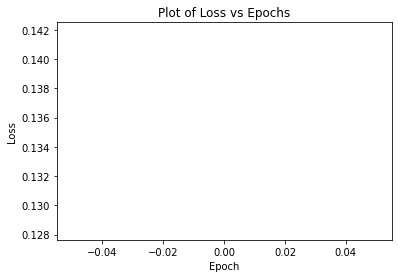

In [36]:
plt.plot(model.loss_hist.keys(),model.loss_hist.values())
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Plot of Loss vs Epochs')
plt.show()

In [37]:
model

PytorchModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

### Load the best model (based on validation set) and evaluate on test set

In [38]:
#RERUN
model = load_model(model_save + 'best.model')#'best.model')
model_save
torch.save(model.state_dict(), model_save + "model_backup.pt")
prediction_dataset = model.train_dataset.sample(n=0)
prediction_dataset.augmentation_off()
prediction_dataset.df = test_df

In [39]:
model_save

'./model/test_for_reformed_dataset/'

In [40]:
test_df

,Microcerculus marginatus,Myioborus miniatus,Thraupis episcopus,bird,Ramphastos tucanus,Xiphorhynchus guttatus,no bird,Celeus grammicus,Zonotrichia capensis,Trogon viridis,Turdus leucomelas,Tolmomyias sulphurescens
file,,,,,,,,,,,,
D:/open_soundscape_files/./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_0.0.wav,0,0,0,0,0,0,0,1,0,0,0,0
D:/open_soundscape_files/./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_3.0.wav,0,0,0,0,0,0,0,1,0,0,0,0
D:/open_soundscape_files/./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_6.0.wav,0,0,0,0,0,0,1,0,0,0,0,0
D:/open_soundscape_files/./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_9.0.wav,0,0,0,0,0,0,0,1,0,0,0,0
D:/open_soundscape_files/./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_12.0.wav,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
D:/open_soundscape_files/./Cosmos_data/Testing/XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_15.0.wav,0,0,0,0,0,0,0,0,0,0,0,1
D:/open_soundscape_files/./Cosmos_data/Testing/XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_18.0.wav,0,0,0,0,0,0,1,0,0,0,0,0
D:/open_soundscape_files/./Cosmos_data/Testing/XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_21.0.wav,0,0,0,0,0,0,0,0,0,0,0,1


In [41]:
prediction_dataset.df

,Microcerculus marginatus,Myioborus miniatus,Thraupis episcopus,bird,Ramphastos tucanus,Xiphorhynchus guttatus,no bird,Celeus grammicus,Zonotrichia capensis,Trogon viridis,Turdus leucomelas,Tolmomyias sulphurescens
file,,,,,,,,,,,,
D:/open_soundscape_files/./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_0.0.wav,0,0,0,0,0,0,0,1,0,0,0,0
D:/open_soundscape_files/./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_3.0.wav,0,0,0,0,0,0,0,1,0,0,0,0
D:/open_soundscape_files/./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_6.0.wav,0,0,0,0,0,0,1,0,0,0,0,0
D:/open_soundscape_files/./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_9.0.wav,0,0,0,0,0,0,0,1,0,0,0,0
D:/open_soundscape_files/./Cosmos_data/Testing/XC87449 - Scaly-breasted Woodpecker - Celeus grammicus subcervinus_12.0.wav,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
D:/open_soundscape_files/./Cosmos_data/Testing/XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_15.0.wav,0,0,0,0,0,0,0,0,0,0,0,1
D:/open_soundscape_files/./Cosmos_data/Testing/XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_18.0.wav,0,0,0,0,0,0,1,0,0,0,0,0
D:/open_soundscape_files/./Cosmos_data/Testing/XC27942 - Yellow-olive Flatbill - Tolmomyias sulphurescens_21.0.wav,0,0,0,0,0,0,0,0,0,0,0,1


In [42]:
model_save

'./model/test_for_reformed_dataset/'

In [43]:
#test_name = "C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/Cosmos_Data/automated_cosmos_tweety_to_file"
#test_df = pd.read_csv(test_name + '_TESTING.csv')

#print(species)
#def fix_classes(label):
#    if (not label in species):
#        return "other"
#    return label
#test_df['MANUAL ID'] = test_df["MANUAL ID"].apply(fix_classes)
#test_df
#classes

In [44]:
#test_name = "C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/OpenSoundScape/MultiClass Classifier/Cosmos_Data/automated_cosmos_tweety_to_file"
#test_df = pd.read_csv(test_name + '_TESTING.csv')
#other_bird = test_df[~(test_df["MANUAL ID"].isin(classes))]
#test_df= test_df[(test_df["MANUAL ID"].isin(classes))]
#other_bird["MANUAL ID"] = "bird"
#test_df

In [45]:
#classes

In [46]:

#test_df = test_df.append(other_bird)
#one_hot_labels, test_classes = categorical_to_one_hot(test_df[['MANUAL ID']].values)
#test_df = pd.DataFrame(index=test_df['file'],data=one_hot_labels,columns=test_classes)
#prediction_dataset.df = test_df

In [47]:
model.classes

['Microcerculus marginatus',
 'Myioborus miniatus',
 'Thraupis episcopus',
 'Ramphastos tucanus',
 'Xiphorhynchus guttatus',
 'no bird',
 'Celeus grammicus',
 'Zonotrichia capensis',
 'Trogon viridis',
 'Turdus leucomelas',
 'Tolmomyias sulphurescens']

In [48]:
prediction_dataset.df = prediction_dataset.df[list(model.classes)]

In [49]:
list(model.classes)

['Microcerculus marginatus',
 'Myioborus miniatus',
 'Thraupis episcopus',
 'Ramphastos tucanus',
 'Xiphorhynchus guttatus',
 'no bird',
 'Celeus grammicus',
 'Zonotrichia capensis',
 'Trogon viridis',
 'Turdus leucomelas',
 'Tolmomyias sulphurescens']

In [52]:
valid_scores_df, valid_preds_df, valid_labels_df = model.predict(prediction_dataset,
                                                                 binary_preds='single_target',
                                                                 batch_size=16,
                                                                 num_workers=2,
                                                                 activation_layer='softmax')

(6434, 11)


#### Print various metrics for the test set predictions

In [ ]:
valid_labels_df.to_csv("valid_labels_df.csv")
valid_labels_df

In [ ]:
valid_preds_df.to_csv("valid_preds_df.csv")
valid_preds_df

In [ ]:
valid_scores_df.to_csv("valid_scores_df.csv")
valid_scores_df

In [ ]:
print(classification_report(valid_labels_df, valid_preds_df, target_names=valid_scores_df.columns))

#### Plot the RIC curve and report AOC

In [ ]:

for species in model.classes:
    fpr, tpr, thresh = roc_curve(valid_labels_df[species],  valid_scores_df[species])
    auc = roc_auc_score(valid_labels_df[species],  valid_preds_df[species])
    plt.plot(fpr,tpr,label= species + " "+str(round(auc, 3)))

plt.title('Classwise ROC Curves')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

In [ ]:
model.classes

***Validate Results***

In [ ]:
model.predict

In [ ]:
model.train_dataset.sample(n=0)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
valid_labels_df[species].values.shape

In [ ]:
test = valid_preds_df.apply(lambda x: sum(x) == 1, axis=1)
test[~test]

In [ ]:
def label(row):
    for col in row:
        print(row[col])
        if row[col] == 1:
            row[col] = col
    return row

In [ ]:
def label(row):
    for col in range(len(valid_labels_df.columns)):
        if row[col] == 1:
            return valid_labels_df.columns[col]
    return "None"

label_confusion = pd.DataFrame(valid_labels_df.apply(label, axis=1))
preds_confusion = pd.DataFrame(valid_preds_df.apply(label, axis=1))

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(label_confusion, preds_confusion,labels=valid_scores_df.columns, normalize='true')
cm_display = ConfusionMatrixDisplay(cm, display_labels=valid_scores_df.columns).plot()

In [ ]:
ConfusionMatrixDisplay.from_predictions(label_confusion, preds_confusion,labels=valid_scores_df.columns)

In [ ]:
import itertools
def plot_confusion_matrix_2(cm,
                      target_names,
                      title='Tweetynet WTS on Opensoundscape with Mixed Bird Other',
                      cmap=None,
                      normalize=True,
                      FONT_SIZE = 10,
                      figsize = (8*2, 6*2)):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions


    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    https://stackoverflow.com/questions/48855290/plotted-confusion-matrix-values-overlapping-each-other-total-classes-90

    """

    #print(cm)
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=figsize)    # 8, 6
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90, fontsize=FONT_SIZE)
        plt.yticks(tick_marks, target_names, fontsize=FONT_SIZE)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #print(cm)
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize=FONT_SIZE,
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize=FONT_SIZE,
                     color="white" if cm[i, j] > thresh else "black")


    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
plot_confusion_matrix_2(cm, target_names=valid_scores_df.columns, FONT_SIZE=15, title=high_level_name)

In [ ]:
valid_scores_df["max"] = valid_scores_df.apply(lambda x : max(x), axis=1)



In [ ]:
plt.hist(valid_scores_df["max"].values)

In [ ]:
plt.hist(valid_scores_df[valid_scores_df["max"] < 0.99]["max"].values)

In [ ]:
valid_scores_df[valid_scores_df["max"] > 0.99].shape

In [ ]:
valid_scores_df[valid_scores_df["max"] < 0.99].shape

In [ ]:
plt.hist(valid_scores_df[~(valid_scores_df["other"] >= valid_scores_df["max"]-0.01)]["max"].values)

In [ ]:
plt.hist(valid_scores_df[~(valid_scores_df["other"] >= valid_scores_df["max"]-0.01) & (valid_scores_df["max"] > 0.99)]["max"].values)

In [ ]:
#plt.hist(valid_scores_df[valid_scores_df["other"] >= valid_scores_df["max"]-0.01]["max"].values)

In [ ]:

#for  col in valid_scores_df.columns:
#    plot.plot
#    plt.hist(valid_scores_df[valid_scores_df[col] >= valid_scores_df["max"]-0.01]["max"].values)

In [ ]:
valid_scores_df.shape

In [ ]:
custom_pred_df = valid_scores_df.copy(deep=True)

In [ ]:
def thresholding(row, threshold=0.20):
    return_row = row.copy()
    for index in row.index:
        return_row[index] = 0

    meets_threshold = False
    for index in row.index:
        if index == "max":
            continue
        if row[index] == row["max"] and row["max"] > threshold and not meets_threshold:
            return_row[index] = 1
            meets_threshold = True
    if (not meets_threshold):
        return_row["Absent"] = 1
    return return_row

#valid_scores_df["other"] = 0
custom_pred_df = valid_scores_df.apply(thresholding, axis=1)
custom_pred_df

def label(row):
    for col in range(len(valid_labels_df.columns)):
        if row[col] == row["max"]:
            return valid_labels_df.columns[col]
    return "Absent"

label_confusion = pd.DataFrame(custom_pred_df.apply(label, axis=1))
#preds_confusion = pd.DataFrame(valid_preds_df.apply(label, axis=1))
preds_confusion_custom = pd.DataFrame(custom_pred_df.apply(label, axis=1))

cm = confusion_matrix(label_confusion, preds_confusion_custom,labels=valid_scores_df.columns)
plot_confusion_matrix_2(cm, target_names=valid_scores_df.columns, FONT_SIZE=15)

In [ ]:

cm = confusion_matrix(label_confusion, preds_confusion_custom,labels=valid_scores_df.columns)
plot_confusion_matrix_2(cm, target_names=valid_scores_df.columns, FONT_SIZE=13)

In [ ]:

for species in model.classes:
    fpr, tpr, thresh = roc_curve(valid_labels_df[species],  valid_scores_df[species])
    auc = roc_auc_score(valid_labels_df[species],  custom_pred_df[species])
    plt.plot(fpr,tpr,label= species + " "+str(round(auc, 3)))

plt.title('Classwise ROC Curves')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

In [ ]:
custom_pred_df = custom_pred_df.drop("max", axis=1)

In [ ]:
def add_other_labels_valid(row):
    if (sum(row) == 0):
        return 1
    return 0
valid_labels_df["other"] = valid_labels_df.apply(add_other_labels_valid, axis=1)
valid_labels_df

In [ ]:
print(classification_report(valid_labels_df, custom_pred_df, target_names=custom_pred_df.columns))

In [ ]:
valid_labels_df.shape


In [ ]:
custom_pred_df.shape